<a href="https://colab.research.google.com/github/mmbs1989/TCC-PUCMINAS/blob/main/Notebook_TCC_PUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL E DE VARIÁVEIS MACROECONÔMICAS UTILIZANDO SÉRIES TEMPORAIS<br>
<br>
ALUNO: Michel Muglia Barbosa Santos</h3>


In [1]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 13.0MB/s 
     |████████████████████████████████| 9.5MB 17.3MB/s 
     |████████████████████████████████| 2.1MB 36.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [2]:
#Bibliotecas básicas do python
import numpy as np 
import seaborn as sns
import pandas as pd
from pandas import DataFrame
from pandas.util.testing import assert_frame_equal
from pandas_datareader import data
import matplotlib.pyplot as plt
import datetime
import math

#Bibliotecas para utilização do Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

#Bibliotecas para utilização do ARIMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
import pmdarima as pm
from pmdarima import auto_arima

#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding
from keras.preprocessing.sequence import TimeseriesGenerator

#Bibliotecas para utilização das métricas do Sklearn
import sklearn.metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# Bibliotecas para uso do statsmodels
import statsmodels.api as sm
from scipy import stats

#Biblioteca para ignorar os warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  




## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DA ARRECADAÇÃO FEDERAL**




In [3]:
# Carregar os dados 
dfarrec = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfa = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcca.csv")

In [4]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfarrec['arrec'] = dfa['a']
dfarrec.head()

,Data,arrec
0,1994-01,4836
1,1994-02,4343
2,1994-03,4418
3,1994-04,5186
4,1994-05,4732


In [ ]:
dfarrec.tail()

,Data,arrec
315,2020-04,101154
316,2020-05,77415
317,2020-06,86258
318,2020-07,115990
319,2020-08,124505


In [5]:
# Retirar as linhas que não serão utilizadas na análise
dfarrec = dfarrec.drop(dfarrec.index[314:])
dfarrec.tail()

,Data,arrec
309,2019-10,135202
310,2019-11,125161
311,2019-12,147501
312,2020-01,174991
313,2020-02,116430


In [6]:
# Transformar o tipo das colunas e definir o index
dfarrec['arrec'] = pd.to_numeric(dfarrec['arrec'])
dfarrec['Data'] = pd.to_datetime(dfarrec['Data'])
dfarrec.set_index('Data', inplace=True)

In [ ]:
dfarrec.head()

,arrec
Data,
1994-01-01,4836
1994-02-01,4343
1994-03-01,4418
1994-04-01,5186
1994-05-01,4732


In [8]:
# Estatísitica descritiva dos valores de arrecadação
dfarrec.describe().astype(int)

,arrec
count,314
mean,54008
std,42247
min,4343
25%,15014
50%,45332
75%,91308
max,174991


In [ ]:
# Confirmar se há valores nulos
dfarrec.isnull().sum()

arrec    0
dtype: int64

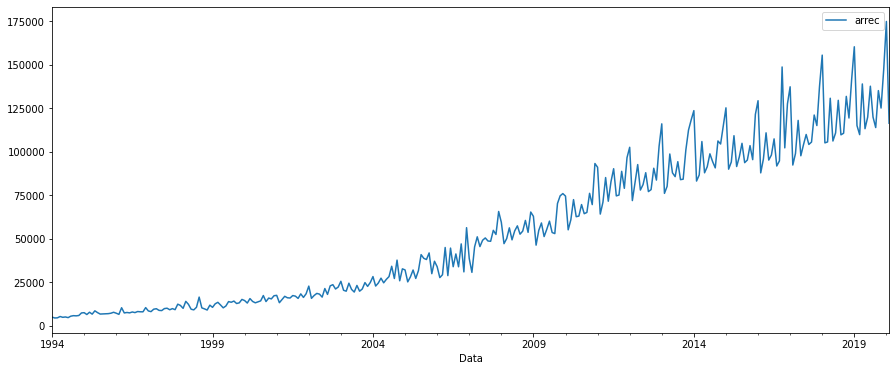

In [ ]:
# Gráfico dos valores
dfarrec.plot(figsize=(15,6))

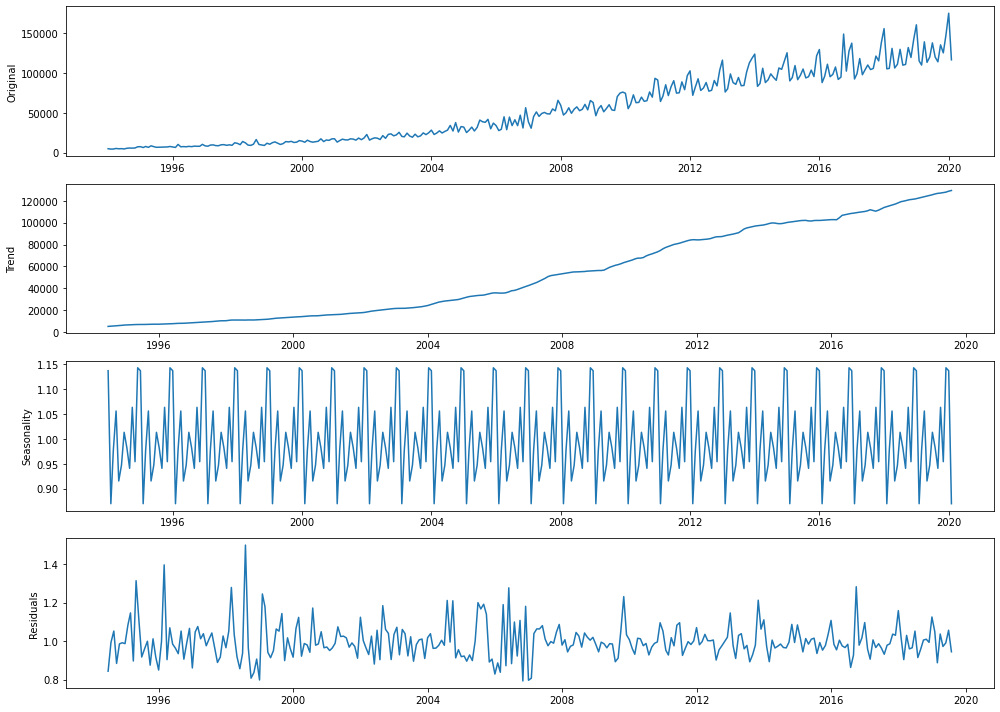

In [9]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfarrec, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfarrec)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

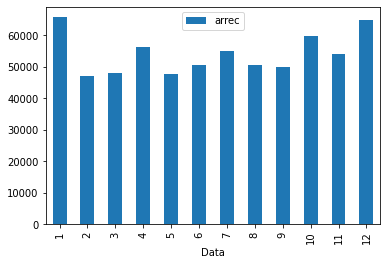

In [ ]:
# Análise dos períodos de sazonalidade
dfarrec.groupby(dfarrec.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DO PIB**




In [10]:
# Carregar os dados
dfpib = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccpib.csv")

In [11]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfpib['pib'] = dfp['pib']
dfpib.head()

,Data,pib
0,1994-01,4563
1,1994-02,5793
2,1994-03,8520
3,1994-04,12829
4,1994-05,20504


In [ ]:
dfpib.tail()

,Data,pib
315,2020-04,543554
316,2020-05,560059
317,2020-06,605147
318,2020-07,631041
319,2020-08,629988


In [12]:
# Retirar as linhas que não serão utilizadas na análise
dfpib = dfpib.drop(dfpib.index[314:])
dfpib.tail()

,Data,pib
309,2019-10,640907
310,2019-11,634654
311,2019-12,647460
312,2020-01,619785
313,2020-02,608644


In [13]:
# Transformar o tipo das colunas e definir o index
dfpib['pib'] = pd.to_numeric(dfpib['pib'])
dfpib['Data'] = pd.to_datetime(dfpib['Data'])
dfpib.set_index('Data', inplace=True)

In [ ]:
dfpib.head()

,pib
Data,
1994-01-01,4563
1994-02-01,5793
1994-03-01,8520
1994-04-01,12829
1994-05-01,20504


In [14]:
# Estatísitica descritiva dos valores de arrecadação
dfpib.describe().astype(int)

,pib
count,314
mean,269371
std,184225
min,4563
25%,101859
50%,216359
75%,448483
max,647460


In [ ]:
# Confirmar se há valores nulos
dfpib.isnull().sum()

pib    0
dtype: int64

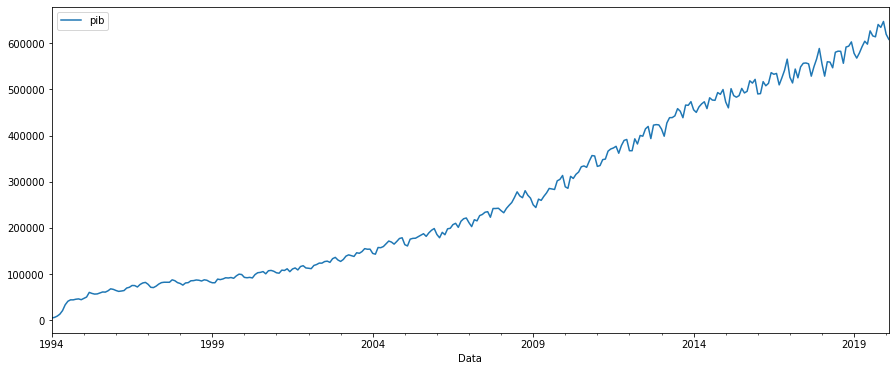

In [ ]:
# Gráfico dos valores
dfpib.plot(figsize=(15,6))

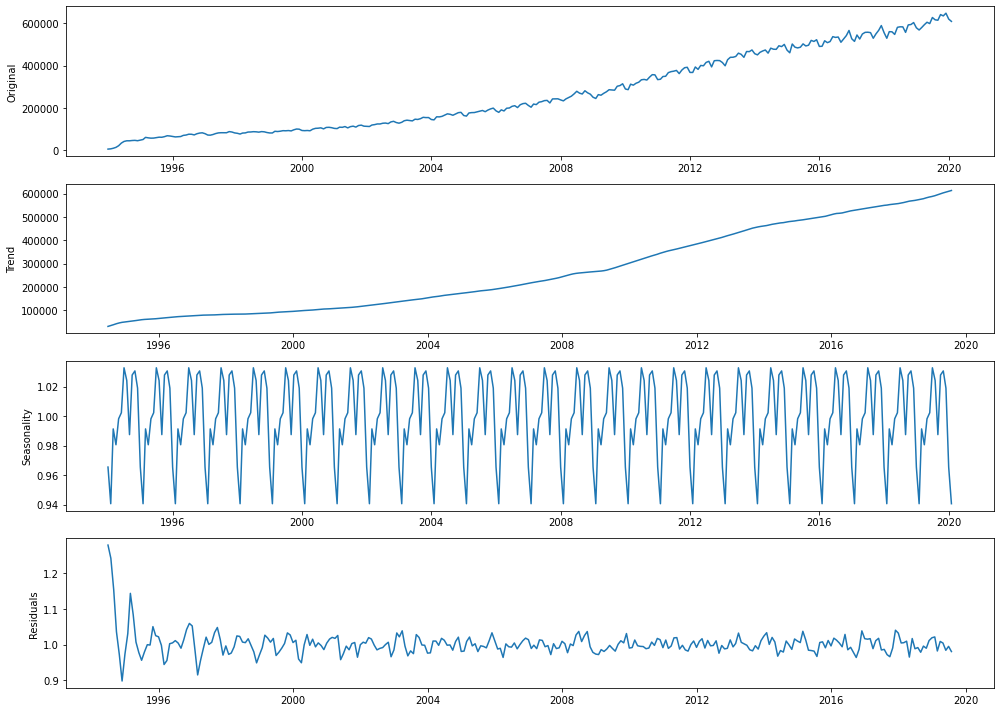

In [15]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfpib, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfpib)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

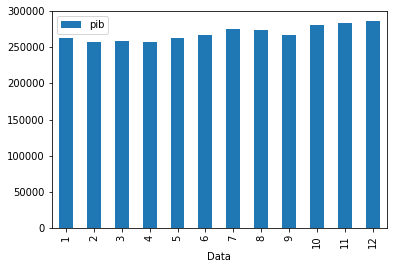

In [ ]:
# Análise dos períodos de sazonalidade
dfpib.groupby(dfpib.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS IMPORTAÇÕES**




In [16]:
# Carregar os dados

dfimp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfi = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcci.csv")

In [17]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfimp['imp'] = dfi['i']
dfimp.head()

,Data,imp
0,1994-01,1768675231
1,1994-02,2030100974
2,1994-03,2248937491
3,1994-04,2151981505
4,1994-05,2624852192


In [ ]:
dfimp.tail()

,Data,imp
315,2020-04,11610871137
316,2020-05,13390915390
317,2020-06,10449294354
318,2020-07,11508172753
319,2020-08,11132508190


In [18]:
# Retirar as linhas que não serão utilizadas na análise
dfimp = dfimp.drop(dfimp.index[314:])
dfimp.tail()

,Data,imp
309,2019-10,17027283951
310,2019-11,14172102789
311,2019-12,12556086388
312,2020-01,16178224141
313,2020-02,13257290693


In [19]:
# Transformar o tipo das colunas e definir o index
dfimp['imp'] = pd.to_numeric(dfimp['imp'])
dfimp['Data'] = pd.to_datetime(dfimp['Data'])
dfimp.set_index('Data', inplace=True)

In [ ]:
dfimp.head()

,imp
Data,
1994-01-01,1768675231
1994-02-01,2030100974
1994-03-01,2248937491
1994-04-01,2151981505
1994-05-01,2624852192


In [20]:
# Estatísitica descritiva dos valores de arrecadação
dfimp.describe().astype(int)

,imp
count,314
mean,9892422722
std,5810018770
min,1768675231
25%,4618010995
50%,8533476810
75%,14601529610
max,23049601170


In [ ]:
# Confirmar se há valores nulos
dfimp.isnull().sum()

imp    0
dtype: int64

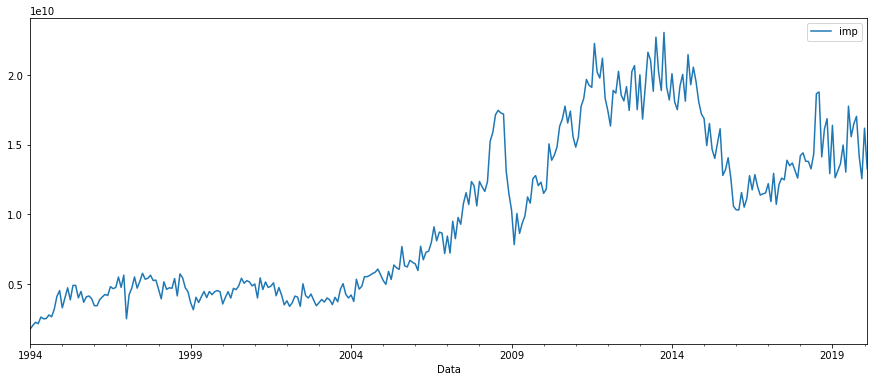

In [ ]:
# Gráfico dos valores
dfimp.plot(figsize=(15,6))

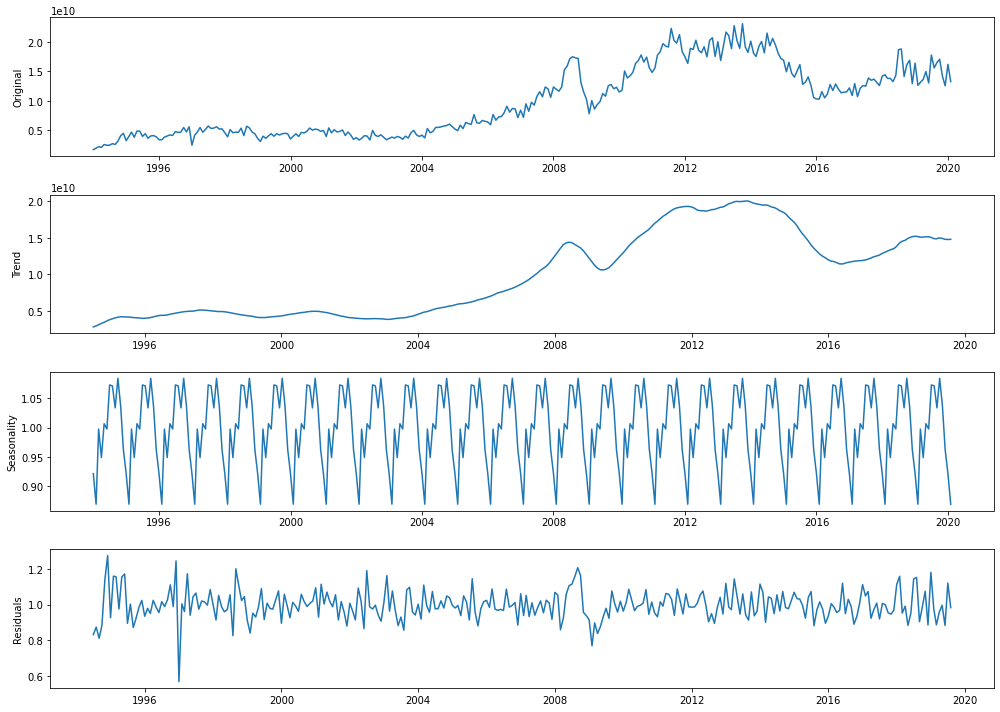

In [21]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfimp, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfimp)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

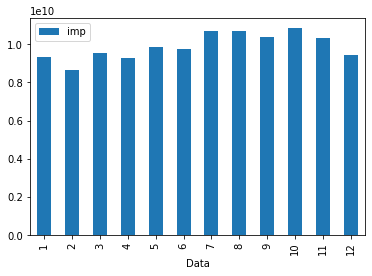

In [ ]:
# Análise dos períodos de sazonalidade
dfimp.groupby(dfimp.index.month).mean().plot(kind='bar')



## **CARREGAMENTO DOS DADOS E ANÁLISE EXPLORATÓRIA DAS EXPORTAÇÕES**




In [22]:
# Carregar os dados

dfexp = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostccdata.csv")
dfe = pd.read_csv("https://raw.githubusercontent.com/mmbs1989/DSWP-Aluno/main/dadostcce.csv")

In [23]:
# Juntar as tabelas carregadas e definir o nome da coluna
dfexp['exp'] = dfe['e']
dfexp.head()

,Data,exp
0,1994-01,2747187653
1,1994-02,2778288879
2,1994-03,3350391558
3,1994-04,3634841763
4,1994-05,3862059965


In [ ]:
dfexp.tail()

,Data,exp
315,2020-04,17612476835
316,2020-05,17546386795
317,2020-06,17514983082
318,2020-07,19453592020
319,2020-08,17484221076


In [24]:
# Retirar as linhas que não serão utilizadas na análise
dfexp = dfexp.drop(dfexp.index[314:])
dfexp.tail()

,Data,exp
309,2019-10,19576839231
310,2019-11,17736715198
311,2019-12,18502977191
312,2020-01,14494583508
313,2020-02,15582390653


In [25]:
# Transformar o tipo das colunas e definir o index
dfexp['exp'] = pd.to_numeric(dfexp['exp'])
dfexp['Data'] = pd.to_datetime(dfexp['Data'])
dfexp.set_index('Data', inplace=True)

In [ ]:
dfexp.head()

,exp
Data,
1994-01-01,2747187653
1994-02-01,2778288879
1994-03-01,3350391558
1994-04-01,3634841763
1994-05-01,3862059965


In [26]:
# Estatísitica descritiva dos valores de arrecadação
dfexp.describe().astype(int)

,exp
count,314
mean,11642469810
std,6617465613
min,2747187653
25%,4632933982
50%,11846627371
75%,17681900227
max,26148242211


In [ ]:
# Confirmar se há valores nulos
dfexp.isnull().sum()

exp    0
dtype: int64

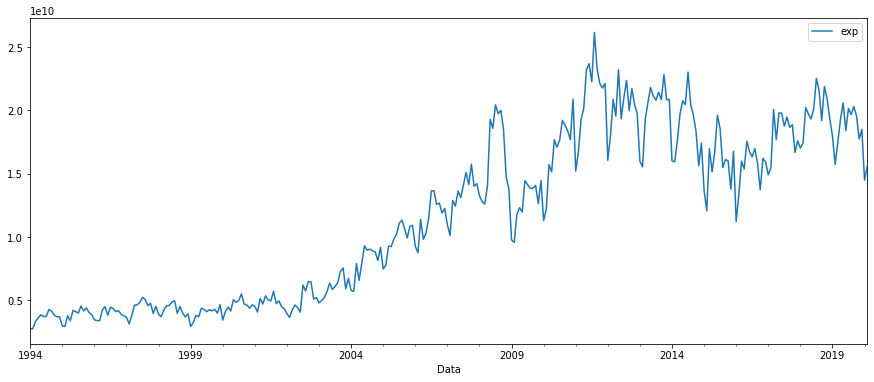

In [ ]:
# Gráfico dos valores
dfexp.plot(figsize=(15,6))

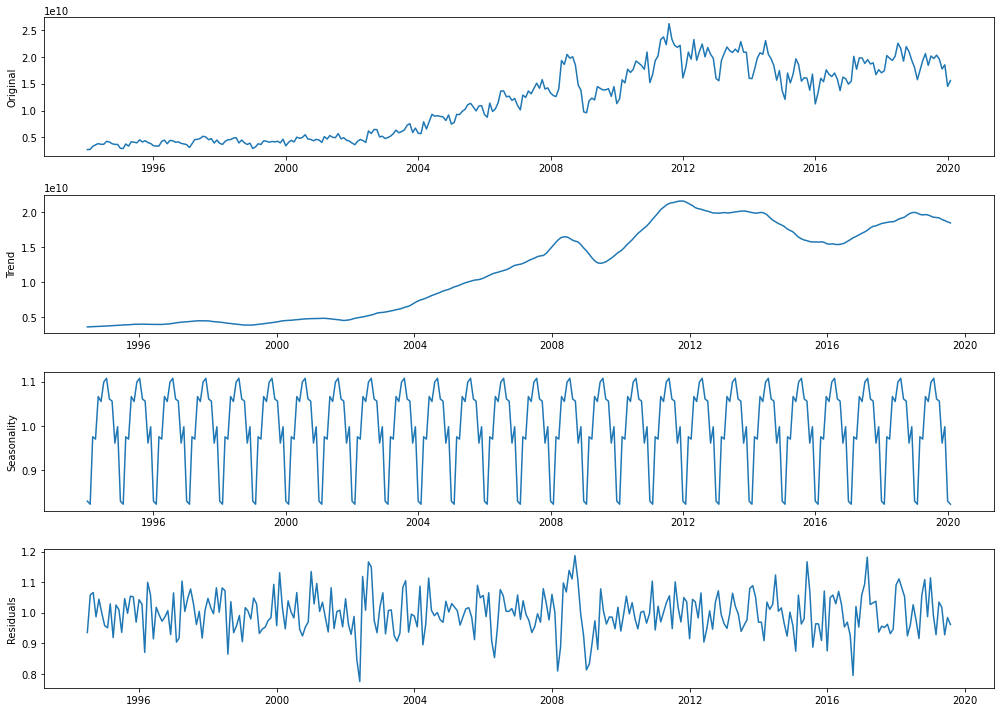

In [27]:
#Decomposição da série temporal
decomposition = seasonal_decompose(dfexp, model='multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(14,10))
plt.subplot(411)
plt.plot(dfexp)
plt.ylabel('Original')
plt.subplot(412)
plt.plot(trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(seasonal)
plt.ylabel('Seasonality')
plt.subplot(414)
plt.plot(residual)
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

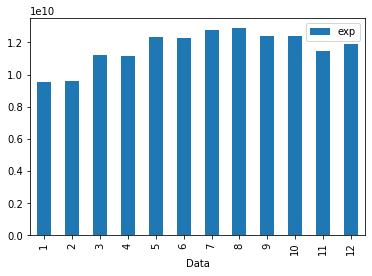

In [ ]:
# Análise dos períodos de sazonalidade
dfexp.groupby(dfexp.index.month).mean().plot(kind='bar')

## **MODELOS PREDITIVOS DA ARRECADAÇÃO FEDERAL**

## Modelo preditivo ARIMA

In [28]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_arima = dfarrec.iloc[:-14].copy()  
dfarrec_test_arima =  dfarrec.iloc[-14:].copy()
dfarrec_test_arima.head()

,arrec
Data,
2019-01-01,160426
2019-02-01,115062
2019-03-01,109854
2019-04-01,139030
2019-05-01,113278


In [29]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
modeloARIMAARREC = auto_arima(dfarrec_train_arima['arrec'], test='adf', trace=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6435.374, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6087.001, Time=0.54 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6239.498, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6433.862, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6389.975, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=6065.329, Time=1.20 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=6284.242, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=6036.571, Time=2.91 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=6045.995, Time=2.73 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=6114.464, Time=2.89 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=6042.330, Time=4.17 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfarrec_train_arima['arrec'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5700.993, Time=1.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5922.820, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5785.124, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5699.424, Time=1.18 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=5781.815, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=5699.614, Time=1.67 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=5718.844, Time=1.11 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=5720.122, Time=1.03 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=5692.038, Time=6.41 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=inf, Time=8.61 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5719.306, Time=1.44 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=5852.188, Time=2.25 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5694.078, Time=9.26 sec
 ARIMA(0,1,2)(1,1,2)[12]             : AIC=inf, Time=7.28 sec
 ARIMA(1,1,0)(1,1,2)[12]     

In [30]:
print(modeloARIMAARREC.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -2973.862
Date:                            Mon, 01 Mar 2021   AIC                           5959.725
Time:                                    17:28:29   BIC                           5981.927
Sample:                                         0   HQIC                          5968.611
                                            - 300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1033      0.049      2.124      0.034       0.008       0.199
ar.L2          0.0334      0.070   

In [31]:
# Treinamento do modelo
modeloARIMAARREC.fit(dfarrec_train_arima['arrec'])

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [32]:
#Faz a predição 
forecast_ARIMAARREC = modeloARIMAARREC.predict(n_periods=len(dfarrec_test_arima['arrec']))
forecast_ARIMAARREC = pd.DataFrame(forecast_ARIMAARREC, index = dfarrec_test_arima.index,columns=['Prediction'])
conf_int = modeloARIMAARREC.predict(len(dfarrec_test_arima['arrec']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

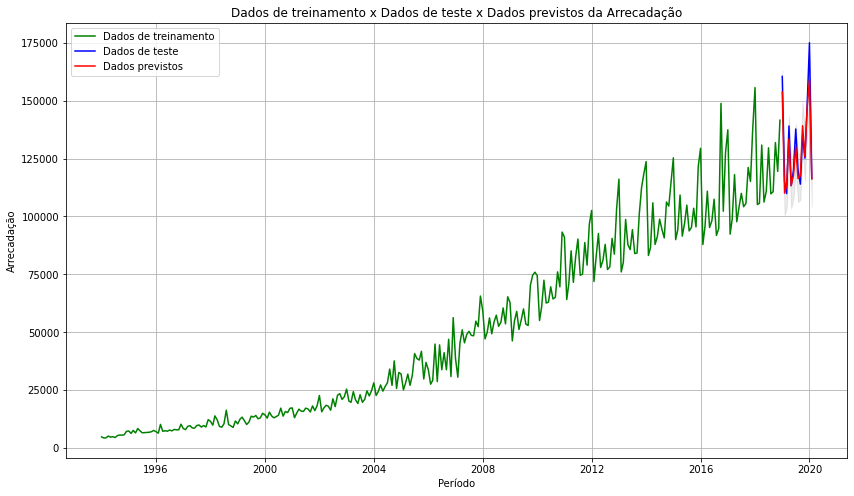

In [33]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_train_arima['arrec'], color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_ARIMAARREC['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

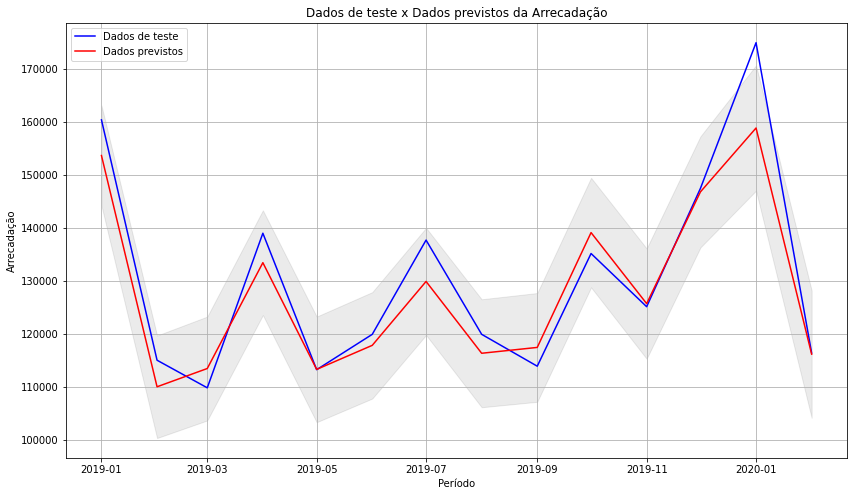

In [34]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos da Arrecadação')
plt.plot(dfarrec_test_arima['arrec'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfarrec_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_ARIMAARREC['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [39]:
#Cálculo do erro
MAEARIMA = int(mean_absolute_error(dfarrec_test_arima['arrec'], forecast_ARIMAARREC['Prediction']))
MSEARIMA = int(mean_squared_error(dfarrec_test_arima['arrec'], forecast_ARIMAARREC['Prediction']))
RMSEARIMA = int(math.sqrt(mean_squared_error(dfarrec_test_arima['arrec'], forecast_ARIMAARREC['Prediction'])))

print('MSE: '+str(MSEARIMA))
print('MAE: '+str(MAEARIMA))
print('RMSE: '+str(RMSEARIMA))

MSE: 34358028
MAE: 4251
RMSE: 5861


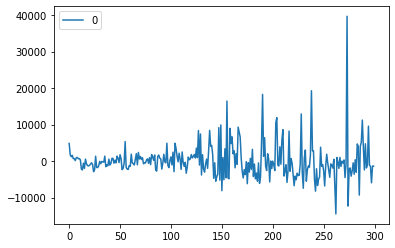

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

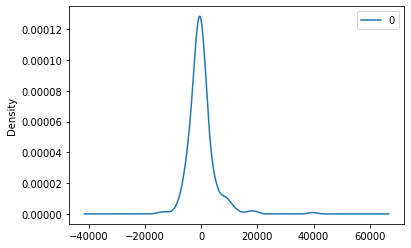

                  0
count    300.000000
mean      56.602514
std     4704.607373
min   -14453.444244
25%    -2198.874580
50%     -498.052384
75%     1283.457862
max    39674.756618


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [40]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_lstm = dfarrec.iloc[:-14].copy()  
dfarrec_test_lstm =  dfarrec.iloc[-14:].copy()

In [41]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfarrec_train_lstm.iloc[:,0:1].values
test_lstm = dfarrec_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [42]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [43]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               161600    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [44]:
lstm_model.fit_generator(generator,epochs=200)

Epoch 1/200
288/288 [==============================] - 4s 8ms/step - loss: 0.0400
Epoch 2/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0062
Epoch 3/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0051
Epoch 4/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0061
Epoch 5/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0045
Epoch 6/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0039
Epoch 7/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0037
Epoch 8/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0047
Epoch 9/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0031
Epoch 10/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0038
Epoch 11/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0055
Epoch 12/200
288/288 [==============================] - 2s 7ms/step - loss: 0.0021
Epoch 13/200


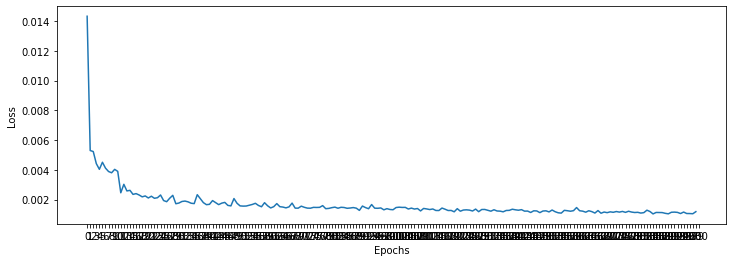

In [46]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,201,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

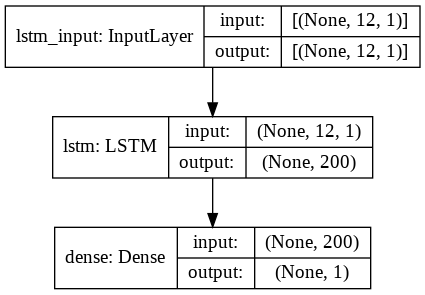

In [47]:
#Visualização do modelo
plot_model(lstm_model, show_shapes=True)

In [48]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [49]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

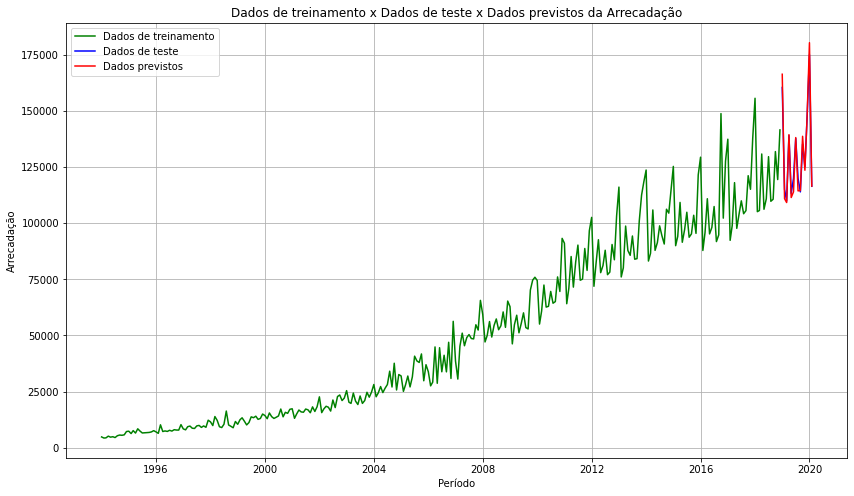

In [51]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.plot(dfarrec_train_lstm.index, dfarrec_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfarrec_test_lstm.index, dfarrec_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()

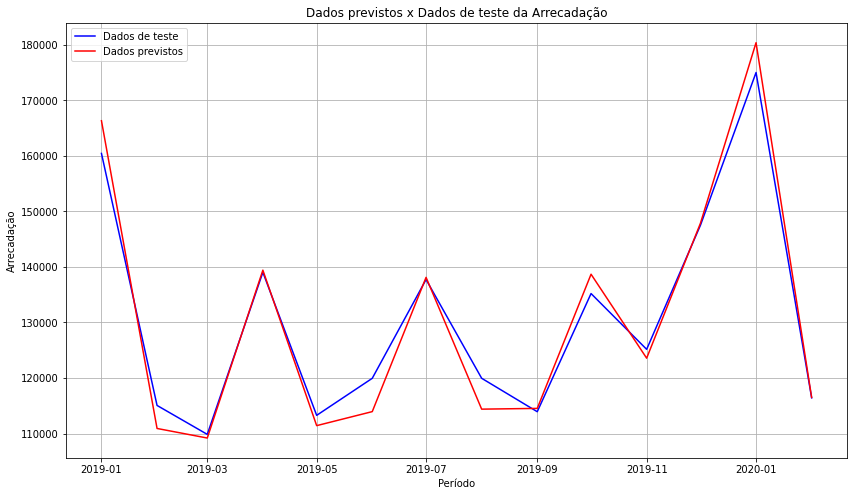

In [52]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(14,8))
plt.plot(dfarrec_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfarrec_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste da Arrecadação')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
#Cálculo do erro
MAELSTM = int(mean_absolute_error(dfarrec_test_lstm,lstm_predictions))
MSELSTM = int(mean_squared_error(dfarrec_test_lstm,lstm_predictions))
RMSELSTM = int(np.sqrt(mean_squared_error(dfarrec_test_lstm,lstm_predictions)))

print('MSE: '+str(MSELSTM))
print('MAE: '+str(MAELSTM))
print('RMSE: '+str(RMSELSTM))

MSE: 11911598
MAE: 2595
RMSE: 3451


## Modelo Preditivo PROPHET

In [54]:
# Definição do conjunto de treinamento e do conjunto de teste
dfarrec_train_prophet = dfarrec.iloc[:-14].copy()  
dfarrec_test_prophet =  dfarrec.iloc[-14:].copy()

In [55]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfarrec_train_prophet = pd.DataFrame({"ds": dfarrec_train_prophet.index, "y": dfarrec_train_prophet.arrec})
dfarrec_train_prophet.reset_index(drop = True, inplace = True)
dfarrec_test_prophet = pd.DataFrame({"ds_test": dfarrec_test_prophet.index, "y_test": dfarrec_test_prophet.arrec})
dfarrec_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfarrec_train_prophet.head()

,ds,y
0,1994-01-01,4836
1,1994-02-01,4343
2,1994-03-01,4418
3,1994-04-01,5186
4,1994-05-01,4732


In [ ]:
dfarrec_test_prophet.head(30)

,ds_test,y_test
0,2019-01-01,160426
1,2019-02-01,115062
2,2019-03-01,109854
3,2019-04-01,139030
4,2019-05-01,113278
5,2019-06-01,119946
6,2019-07-01,137735
7,2019-08-01,119951
8,2019-09-01,113933
9,2019-10-01,135202


In [56]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet()
prophet_model.fit(dfarrec_train_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(41.125, 0.5, 'Arrecadação')

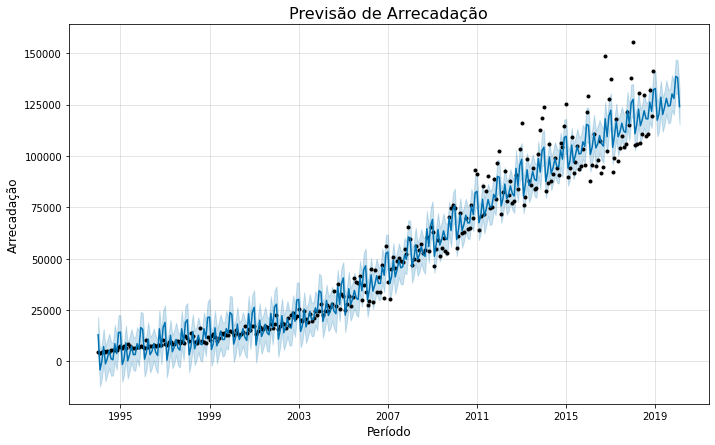

In [57]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão de Arrecadação", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Arrecadação", fontsize=12)

In [58]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,124356.240643,125033.175035,141305.862676,124356.240643,124356.240643,8478.847872,8478.847872,8478.847872,8478.847872,8478.847872,8478.847872,0.0,0.0,0.0,132835.088516
301,2019-02-01,124850.303486,109560.943278,126053.702416,124850.303486,124850.303486,-7454.965244,-7454.965244,-7454.965244,-7454.965244,-7454.965244,-7454.965244,0.0,0.0,0.0,117395.338242
302,2019-03-01,125296.553796,111812.211491,128725.725015,125292.705243,125299.133246,-4934.730676,-4934.730676,-4934.730676,-4934.730676,-4934.730676,-4934.730676,0.0,0.0,0.0,120361.823119
303,2019-04-01,125790.616638,120621.507105,136576.331515,125777.253960,125803.431996,2787.469141,2787.469141,2787.469141,2787.469141,2787.469141,2787.469141,0.0,0.0,0.0,128578.085779
304,2019-05-01,126268.741970,111698.719353,128366.224428,126244.869534,126297.830628,-6115.813858,-6115.813858,-6115.813858,-6115.813858,-6115.813858,-6115.813858,0.0,0.0,0.0,120152.928112


In [59]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfarrec_test_prophet.set_index(dfarrec_test_prophet['ds_test'], inplace=True) 
dfarrec_train_prophet.set_index(dfarrec_train_prophet['ds'], inplace=True) 

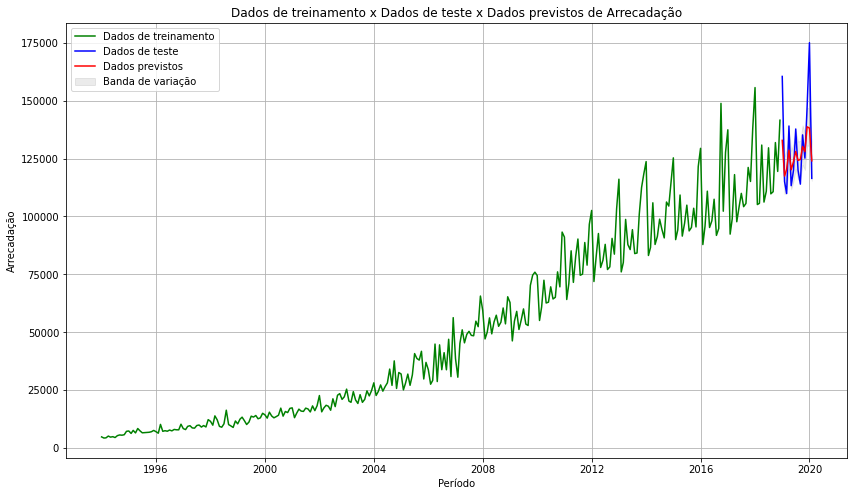

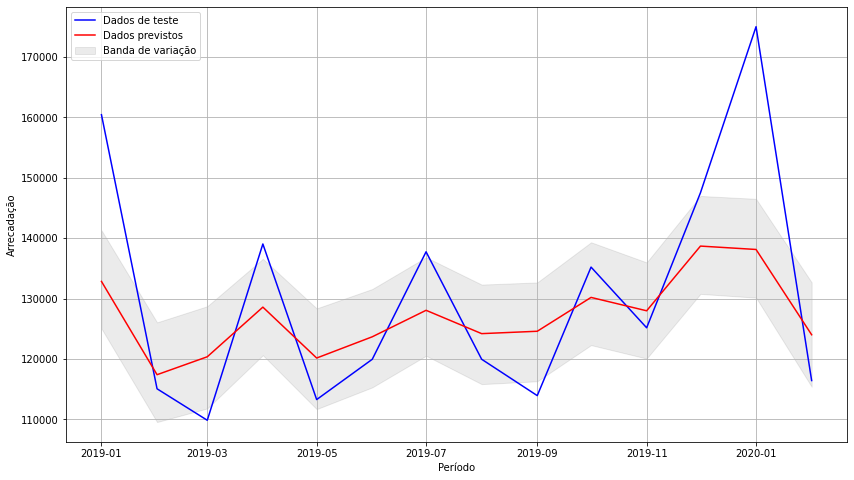

In [60]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfarrec_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos de Arrecadação')
plt.plot(dfarrec_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
plt.grid(True)

#Plotagem do comparativo entre os valores originais com os previstos
plt.figure(figsize=(14,8))
plt.plot(dfarrec_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Arrecadação")
plt.legend()
plt.grid(True)
plt.show()

In [61]:
#Cálculo do erro
MAEPROPHET =  int(mean_absolute_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHET = int(mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHET = int(np.sqrt(mean_squared_error(dfarrec_test_prophet['y_test'],prophet_forecast['yhat'])))

print('MSE: '+str(MSEPROPHET))
print('MAE: '+str(MAEPROPHET))
print('RMSE: '+str(RMSEPROPHET))

MSE: 200026457
MAE: 10510
RMSE: 14143


## Comparativo entre os modelos

In [62]:
#Criar dataframe de comparação entre os modelos
dfarrec_comparativo = dfarrec_test_arima.copy()
dfarrec_comparativo['PREVISÃO_ARIMA'] = forecast_ARIMAARREC['Prediction']
dfarrec_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfarrec_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfarrec_comparativo.head(14)

,arrec,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,160426,153692.638712,132835.088516,166311.209078
2019-02-01,115062,110048.510247,117395.338242,110917.062175
2019-03-01,109854,113496.307918,120361.823119,109194.555927
2019-04-01,139030,133470.432916,128578.085779,139413.353495
2019-05-01,113278,113329.269390,120152.928112,111425.616019
2019-06-01,119946,117870.167577,123669.021680,113950.045161
2019-07-01,137735,129928.830198,128052.490465,138116.465003
2019-08-01,119951,116375.237142,124190.784839,114394.309561
2019-09-01,113933,117477.725599,124583.851815,114529.362476


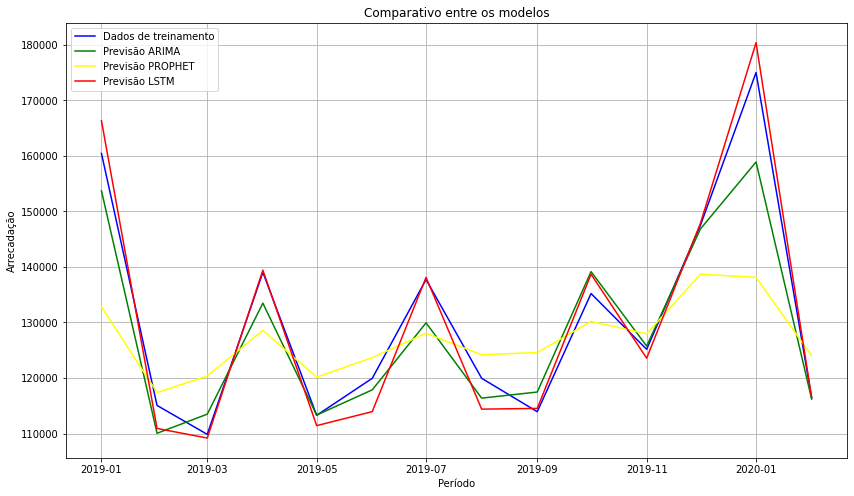

In [68]:
# Plotagem do comparativo entre os modelos
plt.figure(figsize=(14,8))
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["arrec"], color='blue', label = 'Dados de treinamento')
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["PREVISÃO_ARIMA"], color = 'green', label = 'Previsão ARIMA')
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["PREVISÃO_PROPHET"], color = 'yellow', label = 'Previsão PROPHET')
plt.plot(dfarrec_comparativo.index, dfarrec_comparativo["PREVISÃO_LSTM"], color = 'red', label = 'Previsão LSTM')
plt.title('Comparativo entre os modelos')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
plt.show()



In [71]:
#Comparativo dos erros
dfarrec_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfarrec_erro['MAE'] = [MAEARIMA, MAELSTM, MAEPROPHET]
dfarrec_erro['MSE'] = [MSEARIMA, MSELSTM, MSEPROPHET]
dfarrec_erro['RMSE'] = [RMSEARIMA, RMSELSTM, RMSEPROPHET]
dfarrec_erro = dfarrec_erro.sort_values('MAE')
dfarrec_erro.set_index('Modelos', inplace=True)
dfarrec_erro.head()

,MAE,MSE,RMSE
Modelos,,,
LSTM,2595,11911598,3451
ARIMA,4251,34358028,5861
Prophet,10510,200026457,14143


## **MODELOS PREDITIVOS DO PIB**







## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_arima = dfpib.iloc[:-14].copy()  
dfpib_test_arima =  dfpib.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfpib_train_arima['pib'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=5853.507, Time=0.57 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=5964.730, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=5903.095, Time=0.30 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=5853.724, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=5908.871, Time=0.18 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=5853.158, Time=0.74 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=5879.080, Time=0.53 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=5842.195, Time=4.69 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=5862.758, Time=1.27 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=5855.201, Time=3.74 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=5853.204, Time=2.63 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=5852.778, Time=1.44 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=5873.957, Time=1.42 sec
 ARIMA(2,1,1)(2,1,1)[12]             : AIC=5853.135, Time=4.76 sec
 ARIMA(1,1,2)(2,1,1

In [ ]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -2915.098
Date:                            Fri, 19 Feb 2021   AIC                           5842.195
Time:                                    16:41:12   BIC                           5864.152
Sample:                                         0   HQIC                          5850.995
                                            - 300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1355      0.089      1.520      0.129      -0.039       0.310
ma.L1         -0.6300      0.076   

In [ ]:
# Treinamento do modelo
model.fit(dfpib_train_arima['pib'])

ARIMA(maxiter=50, method='lbfgs', order=(1, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(2, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(dfpib_test_arima['pib']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfpib_test_arima.index,columns=['Prediction'])
conf_int = model.predict(len(dfpib_test_arima['pib']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

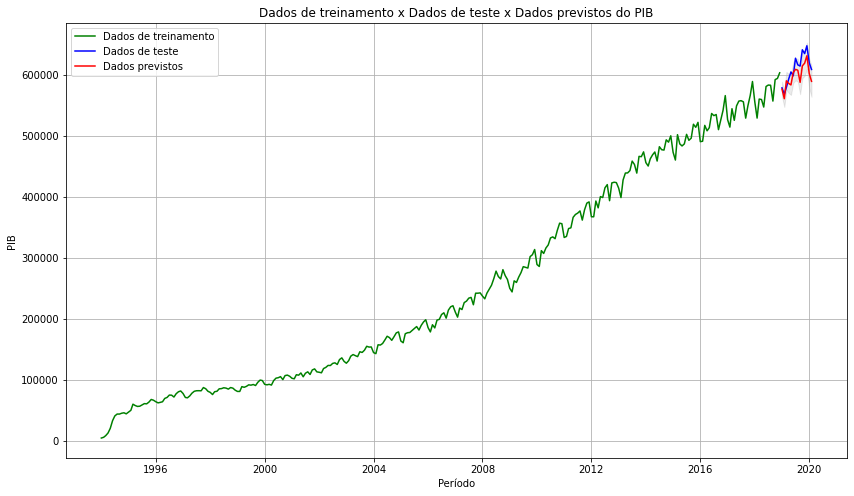

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_train_arima['pib'], color='green', label = 'Dados de treinamento')
plt.plot(dfpib_test_arima['pib'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfpib_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

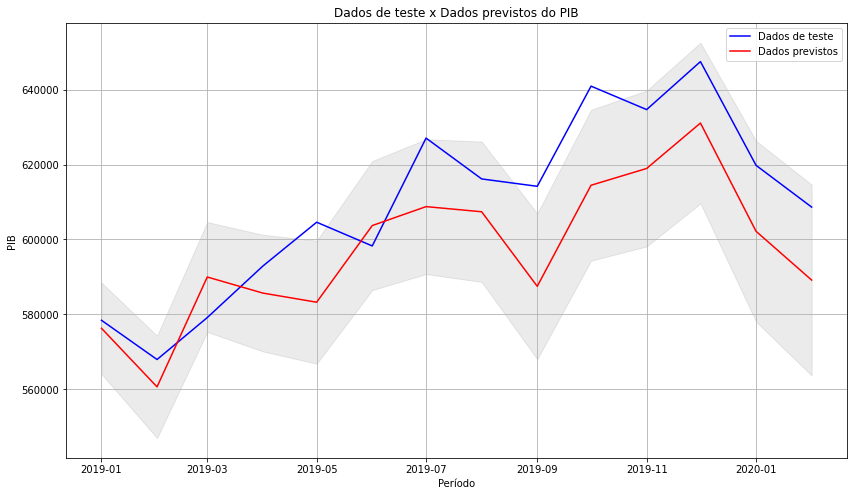

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_test_arima['pib'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfpib_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAEARIMAPIB = int(mean_absolute_error(dfpib_test_arima['pib'], forecast_arima['Prediction']))
MSEARIMAPIB = int(mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction']))
RMSEARIMAPIB = int(math.sqrt(mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction'])))


mse = mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dfpib_test_arima['pib'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dfpib_test_arima['pib'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 266946130.59801453
MAE: 14539.621477775616
RMSE: 16338.486178285139


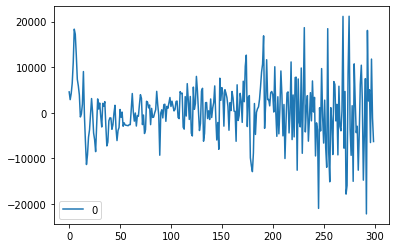

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

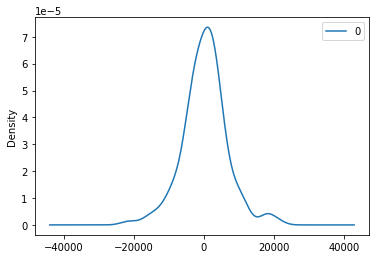

                  0
count    300.000000
mean     327.237730
std     6388.970284
min   -22247.208611
25%    -3042.170693
50%      499.086663
75%     3602.002112
max    21186.404635


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_lstm = dfpib.iloc[:-14].copy()  
dfpib_test_lstm =  dfpib.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfpib_train_lstm.iloc[:,0:1].values
test_lstm = dfpib_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [ ]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=200)

Epoch 1/200
288/288 [==============================] - 3s 10ms/step - loss: 3.1161e-04
Epoch 2/200
288/288 [==============================] - 3s 10ms/step - loss: 3.4823e-04
Epoch 3/200
288/288 [==============================] - 3s 10ms/step - loss: 2.8973e-04
Epoch 4/200
288/288 [==============================] - 3s 10ms/step - loss: 2.5035e-04
Epoch 5/200
288/288 [==============================] - 3s 10ms/step - loss: 2.7691e-04
Epoch 6/200
288/288 [==============================] - 3s 10ms/step - loss: 2.4848e-04
Epoch 7/200
288/288 [==============================] - 3s 10ms/step - loss: 2.5510e-04
Epoch 8/200
288/288 [==============================] - 3s 10ms/step - loss: 3.1882e-04
Epoch 9/200
288/288 [==============================] - 3s 10ms/step - loss: 2.4110e-04
Epoch 10/200
288/288 [==============================] - 3s 10ms/step - loss: 2.3429e-04
Epoch 11/200
288/288 [==============================] - 3s 10ms/step - loss: 3.3112e-04
Epoch 12/200
288/288 [===================

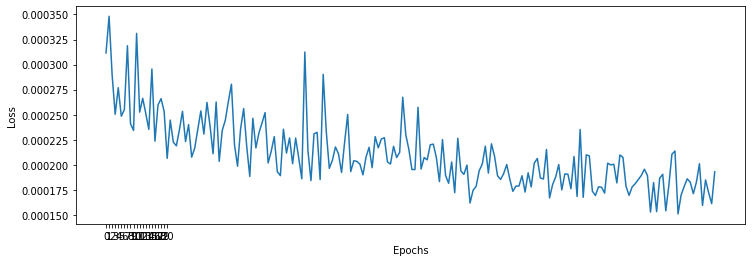

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

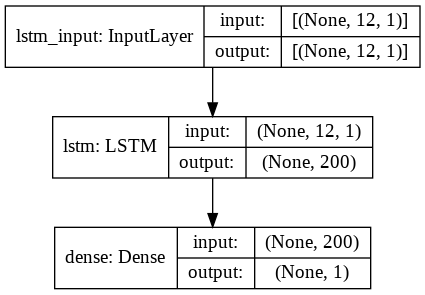

In [ ]:
#Visualização do modelo
plot_model(lstm_model, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

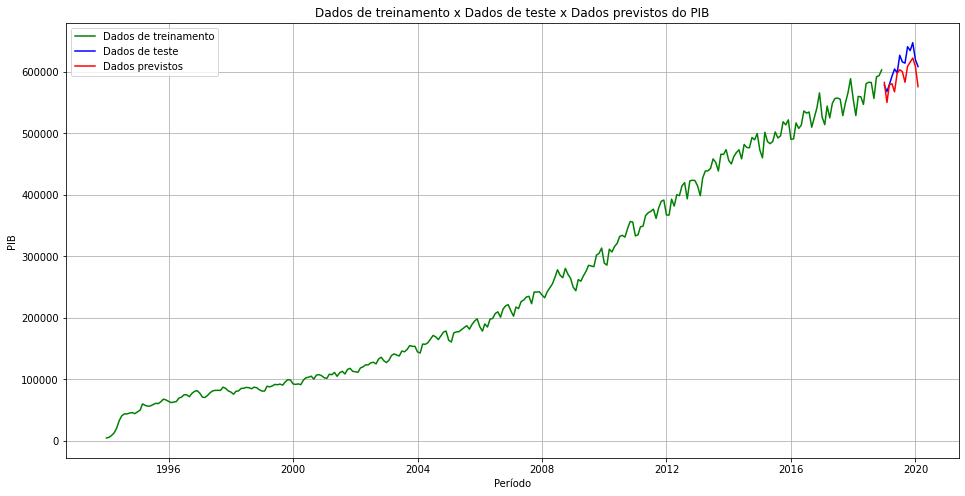

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfpib_train_lstm.index, dfpib_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfpib_test_lstm.index, dfpib_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfpib_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.xlabel('Período')
plt.ylabel('PIB')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

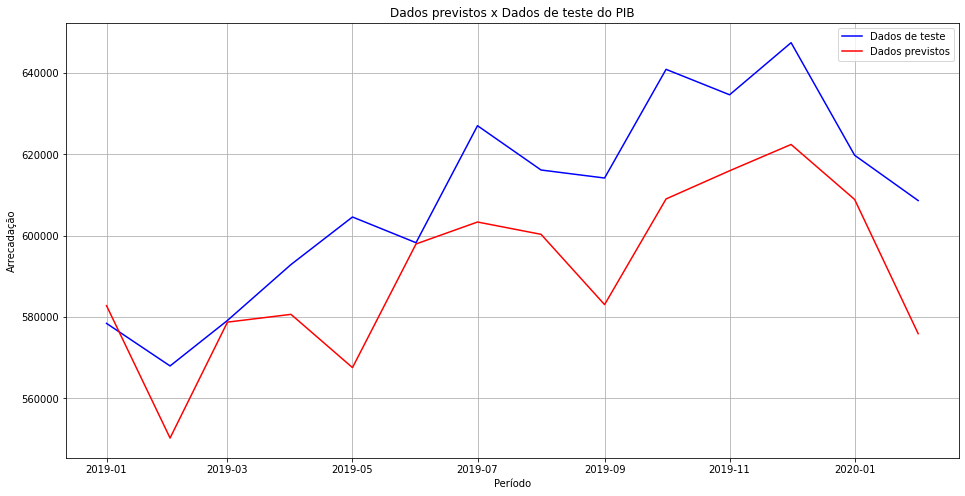

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfpib_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfpib_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste do PIB')
plt.xlabel('Período')
plt.ylabel('Arrecadação')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAELSTMPIB = int(mean_absolute_error(dfpib_test_lstm,lstm_predictions))
MSELSTMPIB = int(mean_squared_error(dfpib_test_lstm,lstm_predictions))
RMSELSTMPIB = int(np.sqrt(mean_squared_error(dfpib_test_lstm,lstm_predictions)))

print('MAE: ', mean_absolute_error(dfpib_test_lstm,lstm_predictions))
print('MSE: ', mean_squared_error(dfpib_test_lstm,lstm_predictions))
print('RMSE: ', np.sqrt(mean_squared_error(dfpib_test_lstm,lstm_predictions)))

MAE:  18702.87713732038
MSE:  486628934.573698
RMSE:  22059.667598894095


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfpib_train_prophet = dfpib.iloc[:-14].copy()  
dfpib_test_prophet =  dfpib.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfpib_train_prophet = pd.DataFrame({"ds": dfpib_train_prophet.index, "y": dfpib_train_prophet.pib})
dfpib_train_prophet.reset_index(drop = True, inplace = True)
dfpib_test_prophet = pd.DataFrame({"ds_test": dfpib_test_prophet.index, "y_test": dfpib_test_prophet.pib})
dfpib_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfpib_train_prophet.head()

,ds,y
0,1994-01-01,4563
1,1994-02-01,5793
2,1994-03-01,8520
3,1994-04-01,12829
4,1994-05-01,20504


In [ ]:
dfpib_test_prophet.head(30)

,ds_test,y_test
0,2019-01-01,578453
1,2019-02-01,567985
2,2019-03-01,579173
3,2019-04-01,592916
4,2019-05-01,604607
5,2019-06-01,598283
6,2019-07-01,627050
7,2019-08-01,616158
8,2019-09-01,614188
9,2019-10-01,640907


In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(dfpib_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(41.375, 0.5, 'PIB')

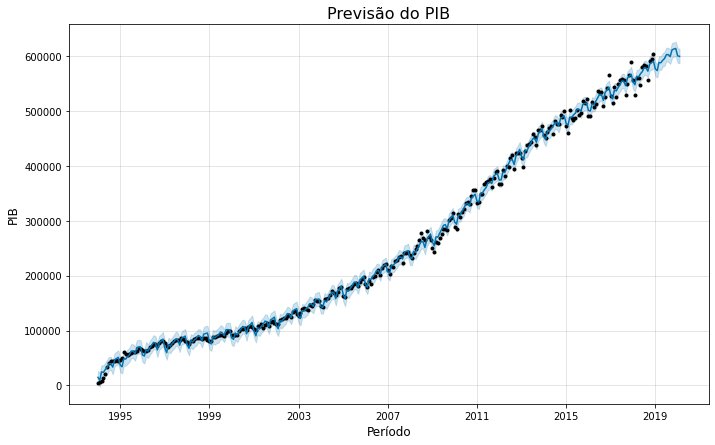

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão do PIB", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("PIB", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,585628.418285,563546.515179,588786.538168,585575.715832,585659.148010,-8855.620867,-8855.620867,-8855.620867,-8855.620867,-8855.620867,-8855.620867,0.0,0.0,0.0,576772.797418
301,2019-02-01,587739.767215,561172.924749,585486.092142,587440.939354,587940.528400,-14103.097244,-14103.097244,-14103.097244,-14103.097244,-14103.097244,-14103.097244,0.0,0.0,0.0,573636.669971
302,2019-03-01,589646.792055,575557.706316,600001.915983,589060.455151,590035.420671,-1355.916698,-1355.916698,-1355.916698,-1355.916698,-1355.916698,-1355.916698,0.0,0.0,0.0,588290.875358
303,2019-04-01,591758.140985,574774.414572,599695.282547,590735.585985,592424.841685,-3869.875112,-3869.875112,-3869.875112,-3869.875112,-3869.875112,-3869.875112,0.0,0.0,0.0,587888.265874
304,2019-05-01,593801.381886,580555.238754,605059.849191,592431.095503,594858.246021,-1500.576474,-1500.576474,-1500.576474,-1500.576474,-1500.576474,-1500.576474,0.0,0.0,0.0,592300.805411


In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfpib_test_prophet.set_index(dfpib_test_prophet['ds_test'], inplace=True) 
dfpib_train_prophet.set_index(dfpib_train_prophet['ds'], inplace=True) 

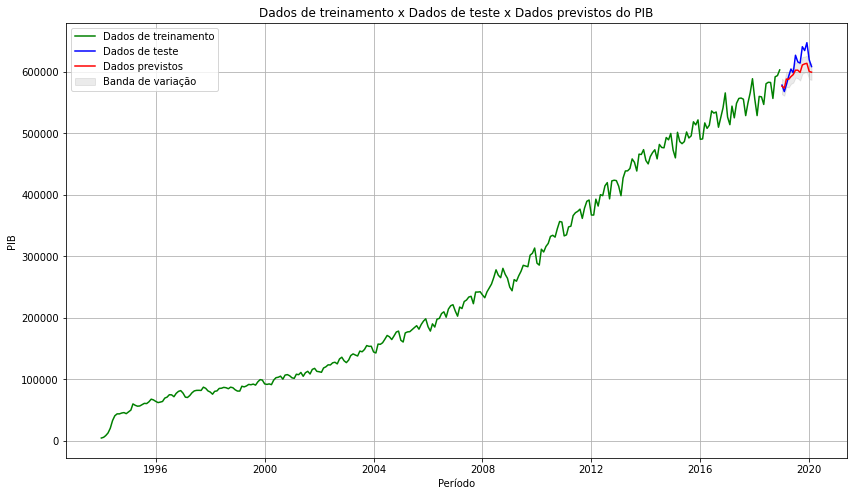

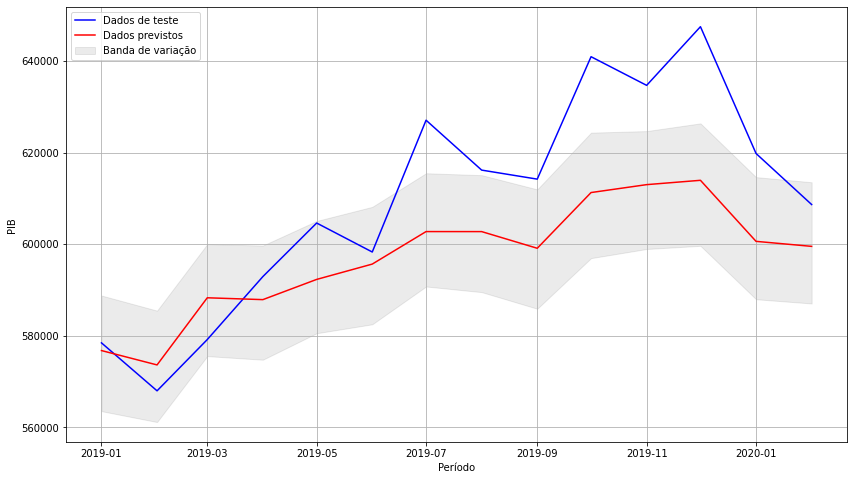

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfpib_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos do PIB')
plt.plot(dfpib_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfpib_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("PIB")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfpib_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("PIB")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAEPROPHETPIB = int(mean_absolute_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHETPIB = int(mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHETPIB = int(np.sqrt(mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat'])))

print('MAE: ', mean_absolute_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dfpib_test_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  14456.372713588835
MSE:  301714278.29169077
RMSE:  17369.924533275633


## Comparativo entre os modelos

In [ ]:
#Criar dataframe de comparação entre os modelos
dfpib_comparativo = dfpib_test_arima.copy()
dfpib_comparativo['PREVISÃO_ARIMA'] = forecast_arima['Prediction']
dfpib_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfpib_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfpib_comparativo.head(14)

,pib,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,578453,576320.353471,576772.797418,598879.494747
2019-02-01,567985,560683.967014,573636.669971,601992.190159
2019-03-01,579173,589993.391027,588290.875358,606373.304848
2019-04-01,592916,585704.953916,587888.265874,609948.897835
2019-05-01,604607,583269.566636,592300.805411,613670.417374
2019-06-01,598283,603719.473078,595646.863223,618052.709465
2019-07-01,627050,608771.344355,602741.567051,621456.615761
2019-08-01,616158,607397.533270,602736.315214,624763.047401
2019-09-01,614188,587509.977710,599099.183260,628054.351204


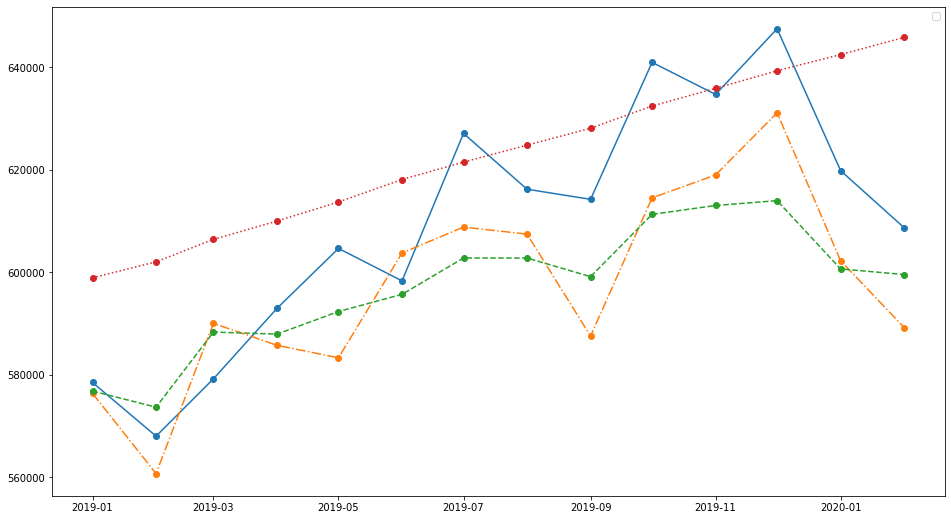

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(dfpib_comparativo.index, dfpib_comparativo["pib"], linestyle="-")
plt.plot_date(dfpib_comparativo.index, dfpib_comparativo["PREVISÃO_ARIMA"], linestyle="-.")
plt.plot_date(dfpib_comparativo.index, dfpib_comparativo["PREVISÃO_PROPHET"], linestyle="--")
plt.plot_date(dfpib_comparativo.index, dfpib_comparativo["PREVISÃO_LSTM"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
#Comparativo dos erros

dfpib_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfpib_erro['MAE'] = [MAEARIMAPIB, MAELSTMPIB, MAEPROPHETPIB]
dfpib_erro['MSE'] = [MSEARIMAPIB, MSELSTMPIB, MSEPROPHETPIB]
dfpib_erro['RMSE'] = [RMSEARIMAPIB, RMSELSTMPIB, RMSEPROPHETPIB]
dfpib_erro.head()

,Modelos,MAE,MSE,RMSE
0,ARIMA,14539,266946130,16338
1,LSTM,16660,386230004,19652
2,Prophet,14456,301714278,17369


## **MODELOS PREDITIVOS DAS IMPORTAÇÕES**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfimp_train_arima = dfimp.iloc[:-14].copy()  
dfimp_test_arima =  dfimp.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfimp_train_arima['imp'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=12796.314, Time=0.56 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12901.784, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12848.831, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=12795.814, Time=0.32 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=12861.988, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=12791.348, Time=0.61 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12841.320, Time=0.30 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=12789.909, Time=1.06 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=12824.917, Time=0.82 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=12788.272, Time=3.65 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=12791.191, Time=2.04 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=12815.793, Time=2.16 sec
 ARIMA(1,1,1)(2,1,2)[12]             : AIC=12789.080, Time=4.57 sec
 ARIMA(0,1,2)(2,1,2)[12]             : AIC=12792.168, Time=1.73 sec
 ARIM

In [ ]:
print(model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  300
Model:             SARIMAX(3, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -6365.807
Date:                              Fri, 19 Feb 2021   AIC                          12745.614
Time:                                      17:03:15   BIC                          12771.231
Sample:                                           0   HQIC                         12755.881
                                              - 300                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4650      0.082    -17.772      0.000      -1.627      -1.303
ar.L2         -1.35

In [ ]:
# Treinamento do modelo
model.fit(dfimp_train_arima['imp'])

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(dfimp_test_arima['imp']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfimp_test_arima.index,columns=['Prediction'])
conf_int = model.predict(len(dfimp_test_arima['imp']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

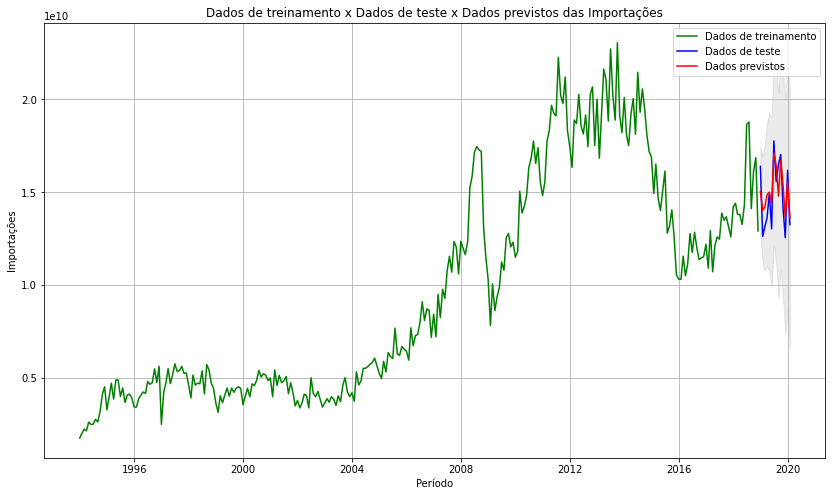

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Importações')
plt.plot(dfimp_train_arima['imp'], color='green', label = 'Dados de treinamento')
plt.plot(dfimp_test_arima['imp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfimp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Importações')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

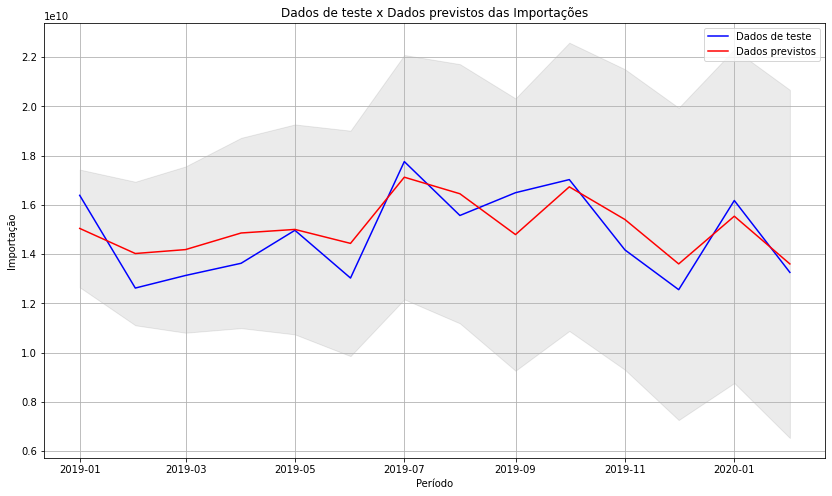

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos das Importações')
plt.plot(dfimp_test_arima['imp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfimp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Importação')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAEARIMAIMP = int(mean_absolute_error(dfimp_test_arima['imp'], forecast_arima['Prediction']))
MSEARIMAIMP = int(mean_squared_error(dfimp_test_arima['imp'], forecast_arima['Prediction']))
RMSEARIMAIMP = int(math.sqrt(mean_squared_error(dfimp_test_arima['imp'], forecast_arima['Prediction'])))


mse = mean_squared_error(dfimp_test_arima['imp'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dfimp_test_arima['imp'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dfimp_test_arima['imp'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 1.1201625275566862e+18
MAE: 946202061.3574803
RMSE: 1058377308.6932118


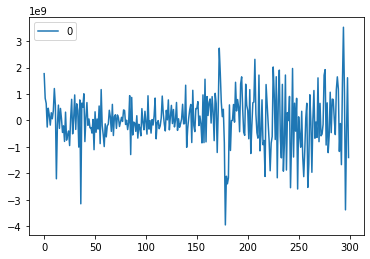

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

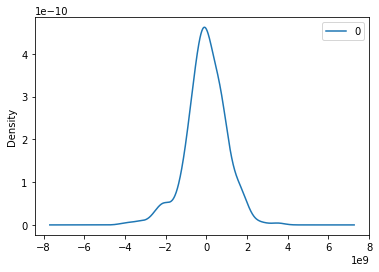

                  0
count  3.000000e+02
mean  -1.459944e+07
std    9.905098e+08
min   -3.953308e+09
25%   -5.365408e+08
50%   -7.018008e+06
75%    6.123858e+08
max    3.524212e+09


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfimp_train_lstm = dfimp.iloc[:-14].copy()  
dfimp_test_lstm =  dfimp.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfimp_train_lstm.iloc[:,0:1].values
test_lstm = dfimp_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [ ]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=300)

Epoch 1/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0030
Epoch 2/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 3/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 4/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 5/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0027
Epoch 6/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 7/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 8/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0028
Epoch 9/300
288/288 [==============================] - 3s 11ms/step - loss: 0.0027
Epoch 10/300
288/288 [==============================] - 3s 11ms/step - loss: 0.0027
Epoch 11/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0029
Epoch 12/300
288/288 [==============================] - 3s 10ms/step - loss: 0.0026
E

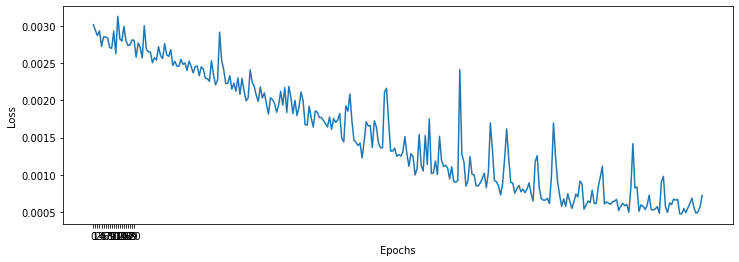

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

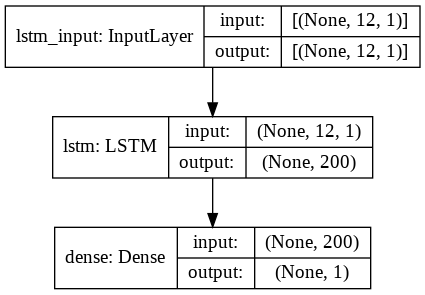

In [ ]:
#Visualização do modelo
plot_model(lstm_model, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

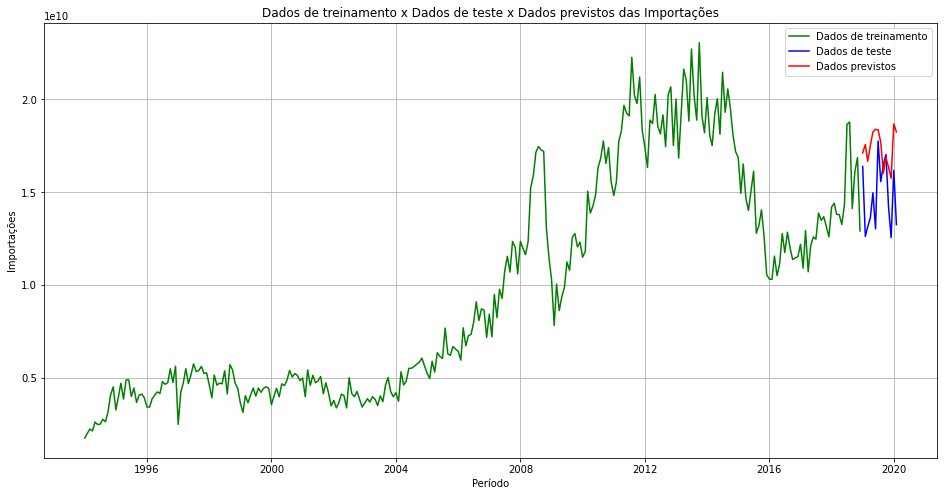

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfimp_train_lstm.index, dfimp_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfimp_test_lstm.index, dfimp_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfimp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Importações')
plt.xlabel('Período')
plt.ylabel('Importações')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

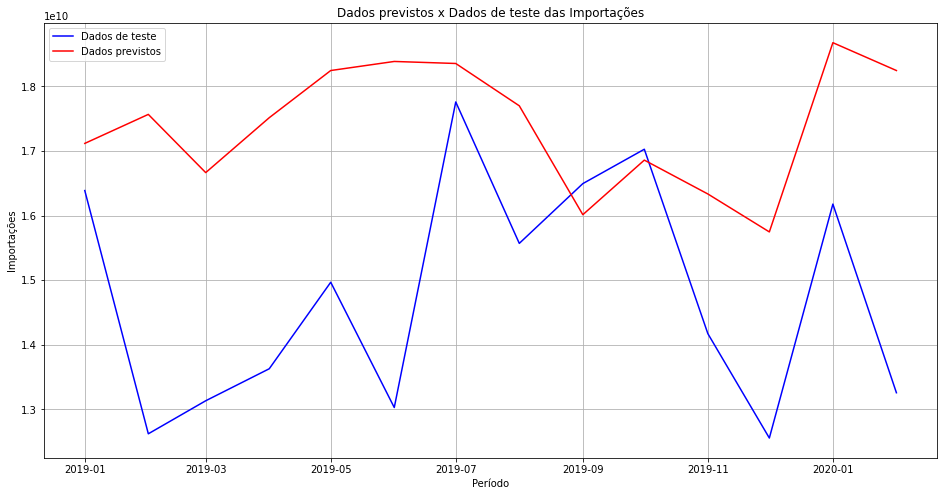

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfimp_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfimp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste das Importações')
plt.xlabel('Período')
plt.ylabel('Importações')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAELSTMIMP = int(mean_absolute_error(dfimp_test_lstm,lstm_predictions))
MSELSTMIMP = int(mean_squared_error(dfimp_test_lstm,lstm_predictions))
RMSELSTMIMP = int(np.sqrt(mean_squared_error(dfimp_test_lstm,lstm_predictions)))

print('MAE: ', mean_absolute_error(dfimp_test_lstm,lstm_predictions))
print('MSE: ', mean_squared_error(dfimp_test_lstm,lstm_predictions))
print('RMSE: ', np.sqrt(mean_squared_error(dfimp_test_lstm,lstm_predictions)))

MAE:  1612606113.6364179
MSE:  4.0392168395277343e+18
RMSE:  2009780296.332844


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfimp_train_prophet = dfimp.iloc[:-14].copy()  
dfimp_test_prophet =  dfimp.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfimp_train_prophet = pd.DataFrame({"ds": dfimp_train_prophet.index, "y": dfimp_train_prophet.imp})
dfimp_train_prophet.reset_index(drop = True, inplace = True)
dfimp_test_prophet = pd.DataFrame({"ds_test": dfimp_test_prophet.index, "y_test": dfimp_test_prophet.imp})
dfimp_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfimp_train_prophet.head()

,ds,y
0,1994-01-01,1768675231
1,1994-02-01,2030100974
2,1994-03-01,2248937491
3,1994-04-01,2151981505
4,1994-05-01,2624852192


In [ ]:
dfimp_test_prophet.head()

,ds_test,y_test
0,2019-01-01,16387829960
1,2019-02-01,12621762837
2,2019-03-01,13132998803
3,2019-04-01,13628618723
4,2019-05-01,14968051867


In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(dfimp_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(63.0, 0.5, 'Importações')

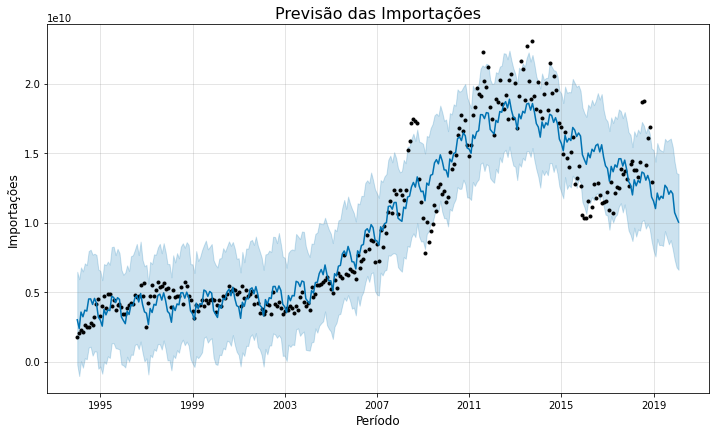

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão das Importações", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Importações", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,1.233547e+10,7.983952e+09,1.521953e+10,1.233223e+10,1.233724e+10,-7.945165e+08,-7.945165e+08,-7.945165e+08,-7.945165e+08,-7.945165e+08,-7.945165e+08,0.0,0.0,0.0,1.154095e+10
301,2019-02-01,1.224730e+10,7.562354e+09,1.438369e+10,1.223130e+10,1.225947e+10,-1.237716e+09,-1.237716e+09,-1.237716e+09,-1.237716e+09,-1.237716e+09,-1.237716e+09,0.0,0.0,0.0,1.100959e+10
302,2019-03-01,1.216767e+10,8.835511e+09,1.572356e+10,1.213300e+10,1.219397e+10,-4.375260e+07,-4.375260e+07,-4.375260e+07,-4.375260e+07,-4.375260e+07,-4.375260e+07,0.0,0.0,0.0,1.212391e+10
303,2019-04-01,1.207950e+10,8.379295e+09,1.528111e+10,1.202161e+10,1.212744e+10,-4.444577e+08,-4.444577e+08,-4.444577e+08,-4.444577e+08,-4.444577e+08,-4.444577e+08,0.0,0.0,0.0,1.163504e+10
304,2019-05-01,1.199418e+10,8.398812e+09,1.517641e+10,1.191375e+10,1.206725e+10,-9.571554e+07,-9.571554e+07,-9.571554e+07,-9.571554e+07,-9.571554e+07,-9.571554e+07,0.0,0.0,0.0,1.189846e+10


In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfimp_test_prophet.set_index(dfimp_test_prophet['ds_test'], inplace=True) 
dfimp_train_prophet.set_index(dfimp_train_prophet['ds'], inplace=True) 

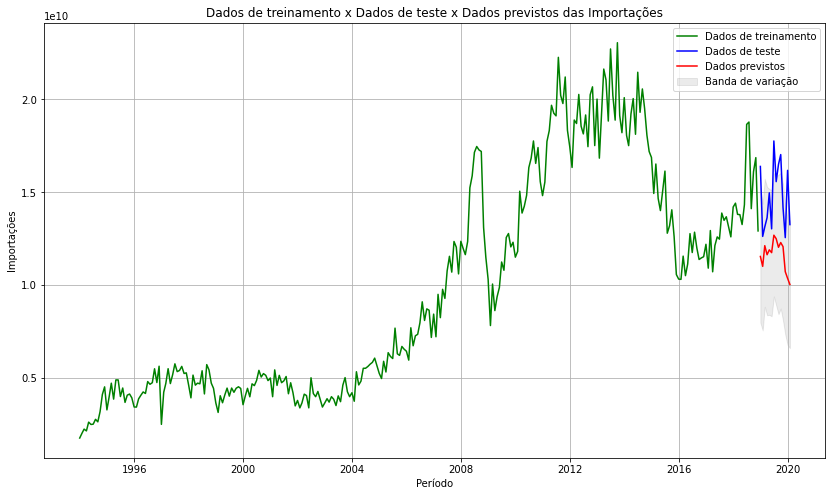

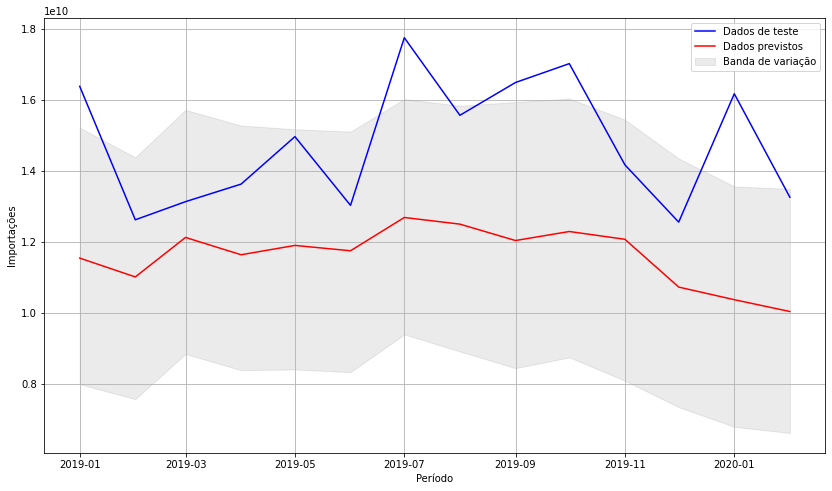

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfimp_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Importações')
plt.plot(dfimp_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfimp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Importações")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfimp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Importações")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAEPROPHETIMP = int(mean_absolute_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHETIMP = int(mean_squared_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHETIMP = int(np.sqrt(mean_squared_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat'])))


print('MAE: ', mean_absolute_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dfimp_test_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  3151316933.297086
MSE:  1.2253513240758243e+19
RMSE:  3500501855.557035


## Comparativo entre os modelos

In [ ]:
#Criar dataframe de comparação entre os modelos
dfimp_comparativo = dfimp_test_arima.copy()
dfimp_comparativo['PREVISÃO_ARIMA'] = forecast_arima['Prediction']
dfimp_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfimp_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfimp_comparativo.head(14)

,imp,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,16387829960,1.504426e+10,1.154095e+10,1.406994e+10
2019-02-01,12621762837,1.402486e+10,1.100959e+10,1.378800e+10
2019-03-01,13132998803,1.418411e+10,1.212391e+10,1.364769e+10
2019-04-01,13628618723,1.485859e+10,1.163504e+10,1.359201e+10
2019-05-01,14968051867,1.500313e+10,1.189846e+10,1.357084e+10
2019-06-01,13028629358,1.443627e+10,1.174755e+10,1.359041e+10
2019-07-01,17759476963,1.712447e+10,1.268689e+10,1.365921e+10
2019-08-01,15569921736,1.645252e+10,1.249907e+10,1.370314e+10
2019-09-01,16495171374,1.479428e+10,1.203635e+10,1.367425e+10


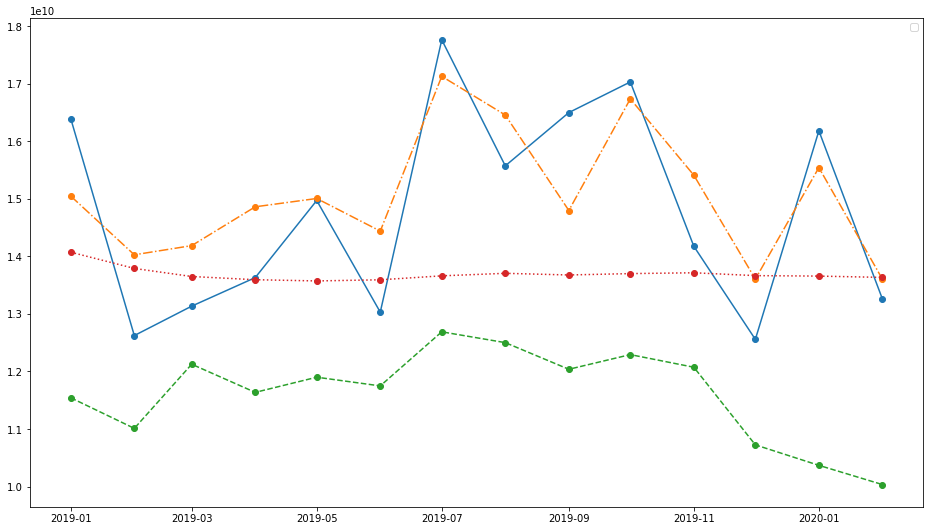

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(dfimp_comparativo.index, dfimp_comparativo["imp"], linestyle="-")
plt.plot_date(dfimp_comparativo.index, dfimp_comparativo["PREVISÃO_ARIMA"], linestyle="-.")
plt.plot_date(dfimp_comparativo.index, dfimp_comparativo["PREVISÃO_PROPHET"], linestyle="--")
plt.plot_date(dfimp_comparativo.index, dfimp_comparativo["PREVISÃO_LSTM"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
#Comparativo dos erros
dfimp_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfimp_erro['MAE'] = [MAEARIMAIMP, MAELSTMIMP, MAEPROPHETIMP]
dfimp_erro['MSE'] = [MSEARIMAIMP, MSELSTMIMP, MSEPROPHETIMP]
dfimp_erro['RMSE'] = [RMSEARIMAIMP, RMSELSTMIMP, RMSEPROPHETIMP]
dfimp_erro.head()

,Modelos,MAE,MSE,RMSE
0,ARIMA,946202061,1120162527556686208,1058377308
1,LSTM,1612606113,4039216839527734272,2009780296
2,Prophet,3151316933,12253513240758243328,3500501855


## **MODELOS PREDITIVOS DAS EXPORTAÇÕES**

## Modelo preditivo ARIMA

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfexp_train_arima = dfexp.iloc[:-14].copy()  
dfexp_test_arima =  dfexp.iloc[-14:].copy()

In [ ]:
# Utilização do auto-arima para identificar o melhor modelo de forma automática
model = auto_arima(dfexp_train_arima['exp'], start_p=1, start_q=1, max_p=3, max_q=3, d=1, stationary = False, start_P=0, D=1, trace=True,
                   error_action='ignore', suppress_warnings=True, stepwise=True, seasonal= True, m=12)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=12825.334, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=12952.519, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=12864.812, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=12823.945, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=12901.899, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=12824.697, Time=0.53 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=12824.652, Time=0.94 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=12857.381, Time=0.26 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=12826.652, Time=2.08 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=12857.581, Time=0.18 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=12826.513, Time=0.41 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=12829.342, Time=0.31 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=12828.394, Time=0.84 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=12826.982, Time=0.41 sec

Best

In [ ]:
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  300
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -6408.973
Date:                            Fri, 19 Feb 2021   AIC                          12823.945
Time:                                    17:19:36   BIC                          12834.924
Sample:                                         0   HQIC                         12828.345
                                            - 300                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3912      0.059     -6.605      0.000      -0.507      -0.275
ma.S.L12      -0.7219      0.054   

In [ ]:
# Treinamento do modelo
model.fit(dfexp_train_arima['exp'])

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 1, 1, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [ ]:
#Faz a predição 
forecast_arima = model.predict(n_periods=len(dfexp_test_arima['exp']))
forecast_arima = pd.DataFrame(forecast_arima, index = dfexp_test_arima.index,columns=['Prediction'])
conf_int = model.predict(len(dfexp_test_arima['exp']), return_conf_int=True, alpha = 0.05) #Pega o intervalo de confiança

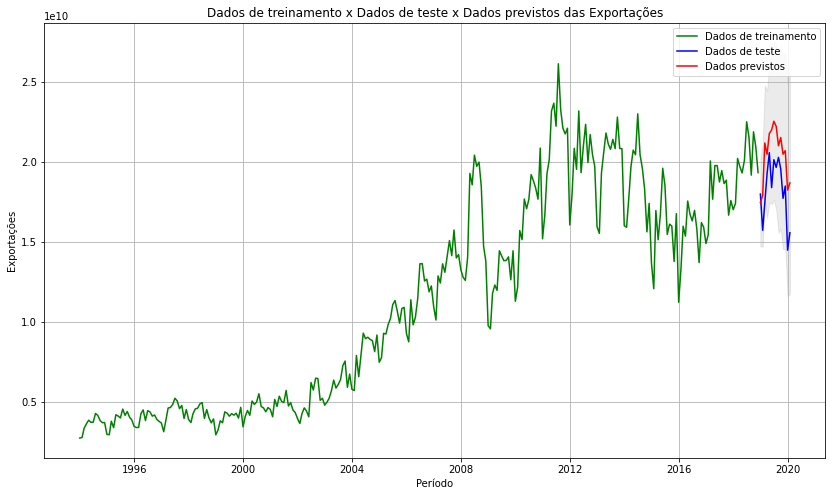

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Exportações')
plt.plot(dfexp_train_arima['exp'], color='green', label = 'Dados de treinamento')
plt.plot(dfexp_test_arima['exp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfexp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
#plt.savefig('arima1.pdf')
plt.show()

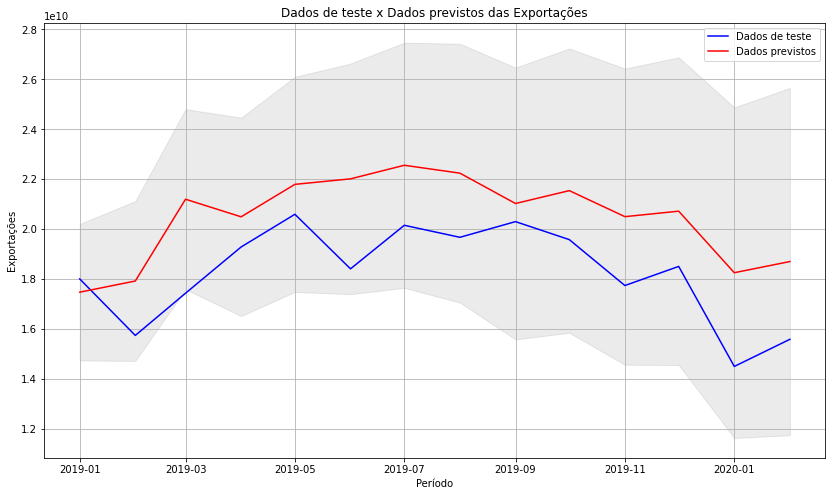

In [ ]:
#Plotagem dos dados de teste e previsão
plt.figure(figsize=(14,8))
plt.title('Dados de teste x Dados previstos das Exportações')
plt.plot(dfexp_test_arima['exp'], color = 'blue', label = 'Dados de teste')
plt.fill_between(dfexp_test_arima.index, conf_int[1][:,0], conf_int[1][:,1], 
                 color='k', alpha=.08)
plt.plot(forecast_arima['Prediction'], color = 'red', label = 'Dados previstos')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
#plt.savefig('arima2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAEARIMAEXP = int(mean_absolute_error(dfexp_test_arima['exp'], forecast_arima['Prediction']))
MSEARIMAEXP = int(mean_absolute_error(dfexp_test_arima['exp'], forecast_arima['Prediction']))
RMSEARIMAEXP = int(math.sqrt(mean_squared_error(dfexp_test_arima['exp'], forecast_arima['Prediction'])))



mse = mean_absolute_error(dfexp_test_arima['exp'], forecast_arima['Prediction'])
print('MSE: '+str(mse))
mae = mean_absolute_error(dfexp_test_arima['exp'], forecast_arima['Prediction'])
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(dfexp_test_arima['exp'], forecast_arima['Prediction']))
print('RMSE: '+str(rmse))

MSE: 2286140453.1406775
MAE: 2286140453.1406775
RMSE: 2510666390.459092


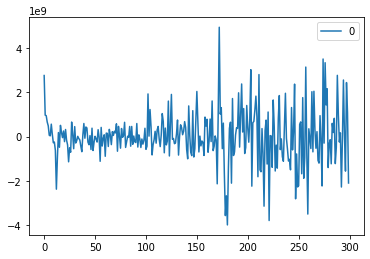

In [ ]:
#Plotagem dos resíduos
residuals = pd.DataFrame(model.resid())
residuals.plot()

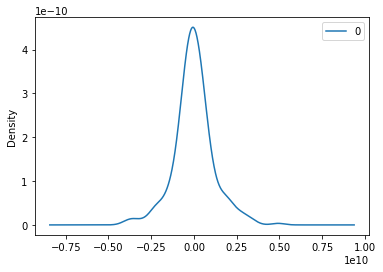

                  0
count  3.000000e+02
mean  -1.953786e+06
std    1.167153e+09
min   -3.981634e+09
25%   -5.472114e+08
50%   -1.704843e+07
75%    5.084246e+08
max    4.921538e+09


In [ ]:
#Plotagem da densidade dos resíduos
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## Modelo Preditivo LSTM

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfexp_train_lstm = dfexp.iloc[:-14].copy()  
dfexp_test_lstm =  dfexp.iloc[-14:].copy()

In [ ]:
#Normalização dos dados
scaler = MinMaxScaler()
train_lstm = dfexp_train_lstm.iloc[:,0:1].values
test_lstm = dfexp_test_lstm.iloc[:,0:1].values
scaler.fit(train_lstm)
scaled_train_data = scaler.transform(train_lstm)
scaled_test_data = scaler.transform(test_lstm)

In [ ]:
# Gerar um objeto de série temporal

n_input = 12
n_features= 1
generator = TimeseriesGenerator(scaled_train_data, scaled_train_data, length=n_input, batch_size=1)

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_model.fit_generator(generator,epochs=200)

Epoch 1/200
288/288 [==============================] - 4s 9ms/step - loss: 0.0245
Epoch 2/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0078
Epoch 3/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0099
Epoch 4/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0064
Epoch 5/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0061
Epoch 6/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0063
Epoch 7/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0057
Epoch 8/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0042
Epoch 9/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0046
Epoch 10/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0048
Epoch 11/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0046
Epoch 12/200
288/288 [==============================] - 3s 9ms/step - loss: 0.0040
Epoch 13/200


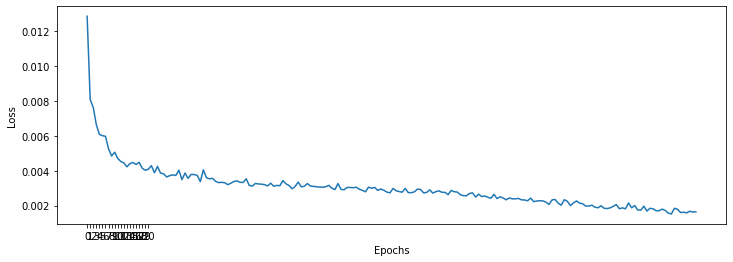

In [ ]:
losses_lstm = lstm_model.history.history['loss']
plt.figure(figsize=(12,4))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
#Visualização do modelo
plot_model(lstm_model, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
lstm_predictions_scaled = list()

batch = scaled_train_data[-n_input:]
current_batch = batch.reshape((1, n_input, n_features))

for i in range(len(test_lstm)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)

In [ ]:
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

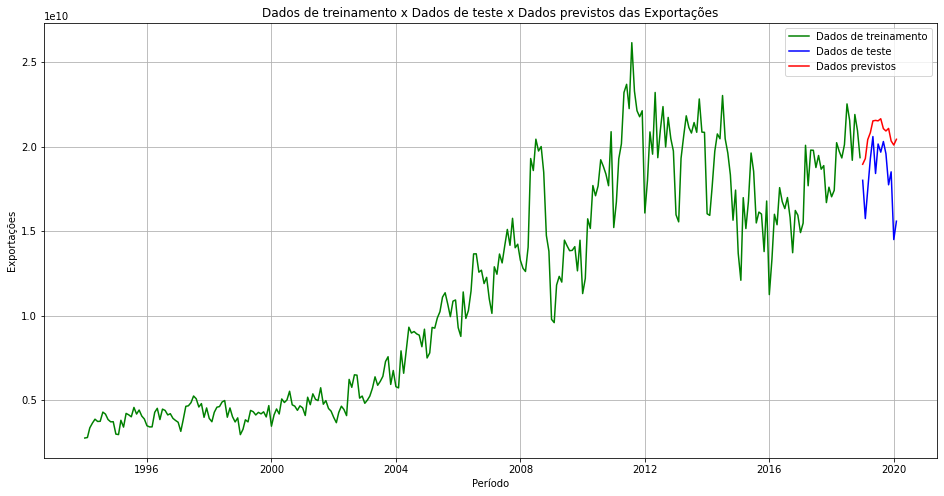

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(dfexp_train_lstm.index, dfexp_train_lstm, color='green', label = 'Dados de treinamento')
plt.plot(dfexp_test_lstm.index, dfexp_test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfexp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Exportações')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

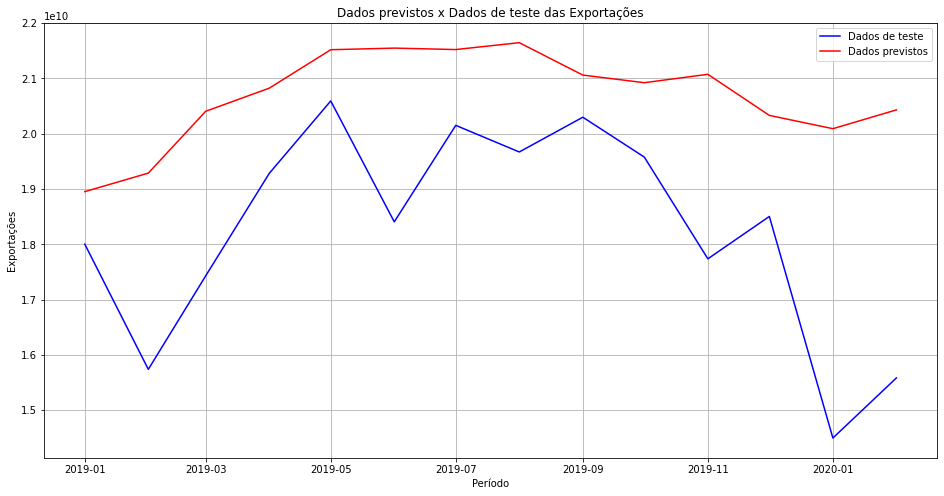

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(16,8))
plt.plot(dfexp_test_lstm.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(dfexp_test_lstm.index, lstm_predictions, color = 'red', label = 'Dados previstos')
plt.title('Dados previstos x Dados de teste das Exportações')
plt.xlabel('Período')
plt.ylabel('Exportações')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAELSTMEXP = int(mean_absolute_error(dfexp_test_lstm,lstm_predictions))
MSELSTMEXP = int(mean_squared_error(dfexp_test_lstm,lstm_predictions))
RMSELSTMEXP = int(np.sqrt(mean_squared_error(dfexp_test_lstm,lstm_predictions)))

print('MAE: ', mean_absolute_error(dfexp_test_lstm,lstm_predictions))
print('MSE: ', mean_squared_error(dfexp_test_lstm,lstm_predictions))
print('RMSE: ', np.sqrt(mean_squared_error(dfexp_test_lstm,lstm_predictions)))

MAE:  2439587188.9823656
MSE:  8.068796332588897e+18
RMSE:  2840562678.869962


## Modelo Preditivo PROPHET

In [ ]:
# Definição do conjunto de treinamento e do conjunto de teste
dfexp_train_prophet = dfexp.iloc[:-14].copy()  
dfexp_test_prophet =  dfexp.iloc[-14:].copy()

In [ ]:
#Renomeia as colunas 'arrec' para 'y' e 'Data' para 'ds' do conjunto de treinamento e teste
dfexp_train_prophet = pd.DataFrame({"ds": dfexp_train_prophet.index, "y": dfexp_train_prophet.exp})
dfexp_train_prophet.reset_index(drop = True, inplace = True)
dfexp_test_prophet = pd.DataFrame({"ds_test": dfexp_test_prophet.index, "y_test": dfexp_test_prophet.exp})
dfexp_test_prophet.reset_index(drop = True, inplace = True)

In [ ]:
dfexp_train_prophet.head()

,ds,y
0,1994-01-01,2747187653
1,1994-02-01,2778288879
2,1994-03-01,3350391558
3,1994-04-01,3634841763
4,1994-05-01,3862059965


In [ ]:
dfexp_test_prophet.head(30)

,ds_test,y_test
0,2019-01-01,18001907016
1,2019-02-01,15737375000
2,2019-03-01,17428698480
3,2019-04-01,19281734438
4,2019-05-01,20592409187
5,2019-06-01,18406010533
6,2019-07-01,20150883169
7,2019-08-01,19669525248
8,2019-09-01,20298407777
9,2019-10-01,19576839231


In [ ]:
#Utiliza a biblioteca Prophet para fazer a previsão
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(dfexp_train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(63.0, 0.5, 'Exportações')

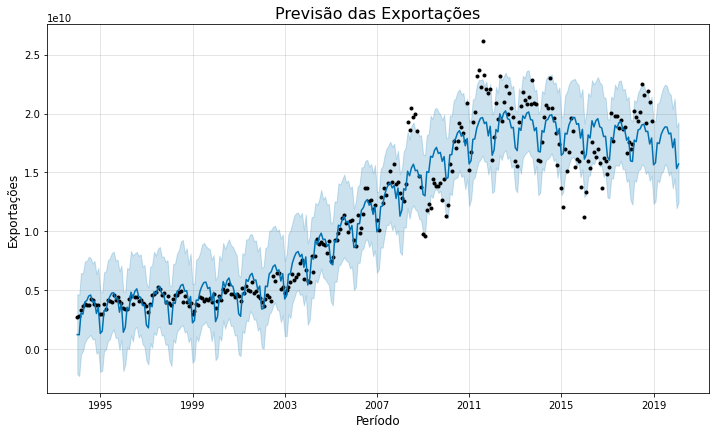

In [ ]:
#Cria datas futuras e faz a predição
prophet_forecast = prophet_model.make_future_dataframe(periods=14, freq='MS')
prophet_forecast = prophet_model.predict(prophet_forecast)

#Plotagem do gráfico de previsão
fig = prophet_model.plot(prophet_forecast)
ax1 = fig.gca()
ax1.set_title("Previsão das Exportações", fontsize=16)
ax1.set_xlabel("Período", fontsize=12)
ax1.set_ylabel("Exportações", fontsize=12)

In [ ]:
#Seleciona os dados previstos apenas para o período de teste
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > '2018-12-01']
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
300,2019-01-01,1.783700e+10,1.233494e+10,1.925773e+10,1.783507e+10,1.783858e+10,-2.186143e+09,-2.186143e+09,-2.186143e+09,-2.186143e+09,-2.186143e+09,-2.186143e+09,0.0,0.0,0.0,1.565085e+10
301,2019-02-01,1.781984e+10,1.253210e+10,1.936671e+10,1.780621e+10,1.782877e+10,-2.000325e+09,-2.000325e+09,-2.000325e+09,-2.000325e+09,-2.000325e+09,-2.000325e+09,0.0,0.0,0.0,1.581952e+10
302,2019-03-01,1.780435e+10,1.434972e+10,2.083363e+10,1.777761e+10,1.782989e+10,-2.865492e+08,-2.865492e+08,-2.865492e+08,-2.865492e+08,-2.865492e+08,-2.865492e+08,0.0,0.0,0.0,1.751780e+10
303,2019-04-01,1.778720e+10,1.416130e+10,2.092298e+10,1.774543e+10,1.783408e+10,-3.404899e+08,-3.404899e+08,-3.404899e+08,-3.404899e+08,-3.404899e+08,-3.404899e+08,0.0,0.0,0.0,1.744671e+10
304,2019-05-01,1.777060e+10,1.490845e+10,2.160064e+10,1.770788e+10,1.783367e+10,4.465952e+08,4.465952e+08,4.465952e+08,4.465952e+08,4.465952e+08,4.465952e+08,0.0,0.0,0.0,1.821720e+10


In [ ]:
#Escolhe as datas ('ds' e 'ds_test') como índices
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True) 
dfexp_test_prophet.set_index(dfexp_test_prophet['ds_test'], inplace=True) 
dfexp_train_prophet.set_index(dfexp_train_prophet['ds'], inplace=True) 

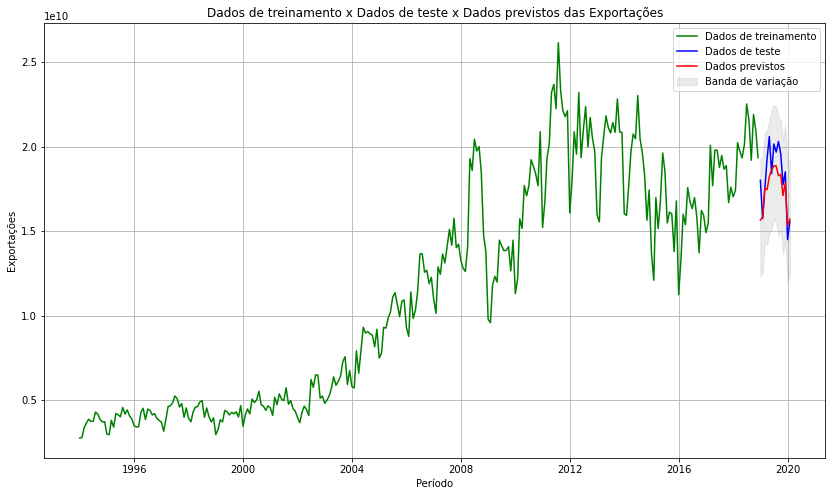

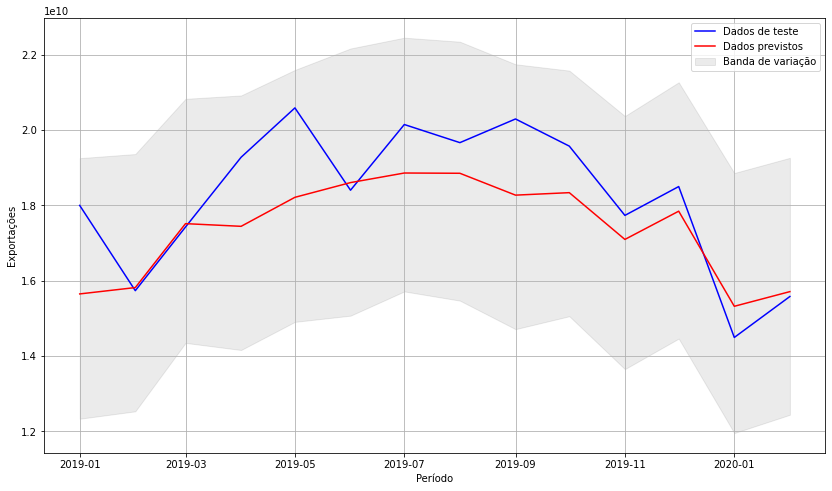

In [ ]:
#Plotagem do comparativo entre o preço previsto e o dataset
n = dfexp_train_prophet.shape[0]
plt.figure(figsize=(14,8))
plt.title('Dados de treinamento x Dados de teste x Dados previstos das Exportações')
plt.plot(dfexp_train_prophet['y'], 'green', label='Dados de treinamento')
plt.plot(dfexp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'][-n:], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Exportações")
plt.legend()
#plt.savefig('prophet1.pdf')
plt.grid(True)

#Plotagem do comparativo entre o preço previsto e o preço de validação
plt.figure(figsize=(14,8))
plt.plot(dfexp_test_prophet['y_test'], color = 'blue', label='Dados de teste')
plt.plot(prophet_forecast['yhat'], color = 'red', label = 'Dados previstos')
plt.fill_between(prophet_forecast.index[-n:], prophet_forecast['yhat_lower'][-n:], prophet_forecast['yhat_upper'][-n:], color='k', alpha=.08, label="Banda de variação")
plt.xlabel("Período")
plt.ylabel("Exportações")
plt.legend()
plt.grid(True)
#plt.savefig('prophet2.pdf')
plt.show()

In [ ]:
#Cálculo do erro
MAEPROPHETEXP = int(mean_absolute_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat']))
MSEPROPHETEXP = int(mean_squared_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat']))
RMSEPROPHETEXP = int(np.sqrt(mean_squared_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat'])))



print('MAE: ', mean_absolute_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat']))
print('MSE: ', mean_squared_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(dfexp_test_prophet['y_test'],prophet_forecast['yhat'])))

MAE:  1039005659.5966362
MSE:  1.7195106910190433e+18
RMSE:  1311301144.29106


## Comparativo entre os modelos

In [ ]:
#Criar dataframe de comparação entre os modelos
dfexp_comparativo = dfexp_test_arima.copy()
dfexp_comparativo['PREVISÃO_ARIMA'] = forecast_arima['Prediction']
dfexp_comparativo['PREVISÃO_PROPHET'] = prophet_forecast['yhat']
dfexp_comparativo['PREVISÃO_LSTM'] = lstm_predictions
dfexp_comparativo.head(14)

,exp,PREVISÃO_ARIMA,PREVISÃO_PROPHET,PREVISÃO_LSTM
Data,,,,
2019-01-01,18001907016,1.747025e+10,1.565085e+10,1.944013e+10
2019-02-01,15737375000,1.791793e+10,1.581952e+10,1.941159e+10
2019-03-01,17428698480,2.119548e+10,1.751780e+10,1.989110e+10
2019-04-01,19281734438,2.049093e+10,1.744671e+10,2.021570e+10
2019-05-01,20592409187,2.179144e+10,1.821720e+10,2.051297e+10
2019-06-01,18406010533,2.201197e+10,1.860807e+10,2.092029e+10
2019-07-01,20150883169,2.255659e+10,1.886270e+10,2.146010e+10
2019-08-01,19669525248,2.224070e+10,1.885575e+10,2.160443e+10
2019-09-01,20298407777,2.102436e+10,1.827496e+10,2.145024e+10


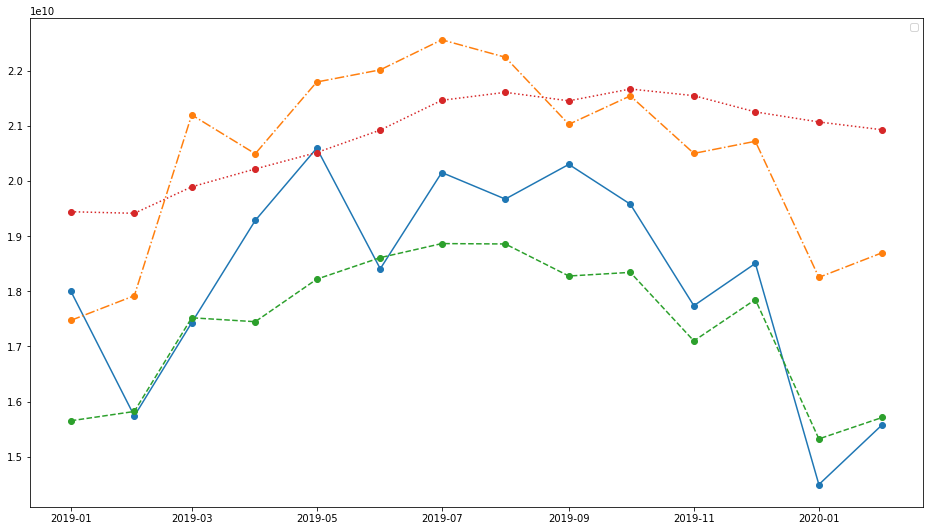

In [ ]:
plt.figure(figsize=(16,9))
plt.plot_date(dfexp_comparativo.index, dfexp_comparativo["exp"], linestyle="-")
plt.plot_date(dfexp_comparativo.index, dfexp_comparativo["PREVISÃO_ARIMA"], linestyle="-.")
plt.plot_date(dfexp_comparativo.index, dfexp_comparativo["PREVISÃO_PROPHET"], linestyle="--")
plt.plot_date(dfexp_comparativo.index, dfexp_comparativo["PREVISÃO_LSTM"], linestyle=":")
plt.legend()
plt.show()

In [ ]:
#Comparativo dos erros
dfexp_erro = pd.DataFrame({"Modelos" : ["ARIMA", "LSTM", "Prophet"]})
dfexp_erro['MAE'] = [MAEARIMAEXP, MAELSTMEXP, MAEPROPHETEXP]
dfexp_erro['MSE'] = [MSEARIMAEXP, MSELSTMEXP, MSEPROPHETEXP]
dfexp_erro['RMSE'] = [RMSEARIMAEXP, RMSELSTMEXP, RMSEPROPHETEXP]
dfexp_erro.head()

,Modelos,MAE,MSE,RMSE
0,ARIMA,2286140453,2286140453,2510666390
1,LSTM,2575384823,9554129599274305536,3090975509
2,Prophet,1039005659,1719510691019043328,1311301144
